 # Introduction to Working with Zarr in Python



 This notebook provides an overview of how to handle large climate datasets using the `xarray` library with Zarr, a powerful storage format optimized for chunked, compressed, and parallel I/O.



 The steps include:

 - Opening existing Zarr datasets.

 - Modifying chunk sizes for optimization.

 - Plotting specific data from the dataset.

 - Saving the modified datasets to new Zarr files.

 - Concatenating multiple Zarr files along the time dimension.

 - Converting data from NetCDF to Zarr format.



 ## Required Libraries

 Make sure you have the necessary Python libraries installed, including `xarray`, `zarr`, and `matplotlib`.

In [13]:
# %%
import xarray as xr
import zarr
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import itertools

import sys
from pathlib import Path
functions_path = Path("/home/mokr/Loss_Functions_Paper/ML_Functions/")
sys.path.append(str(functions_path))

import ML_functions
from ML_functions import HydroDataset

import torch
import torch.nn as nn

In [ ]:
# G_Model_CMAL3 = torch.load('/home/mokr/Loss_Functions_Paper/Models/G_Model_CMAL_Binary_GPU_Bidirectional_3103.pth', map_location=torch.device('cpu'))

# Example where model is okay
# G_Model_CMAL3 = torch.load('/home/mokr/Loss_Functions_Paper/Models/hyperparameter_test/model_lr_0.001_bi_False_h_64_64_32_0425.pth', map_location=torch.device('cpu')) 

Binary_Model =  torch.load('/home/mokr/Loss_Functions_Paper/Models/Binary/hyperparameter_test/Binary_lr_0.001_bi_False_h_256_256_256_0506_30Epochs.pth', map_location=torch.device('cpu')) # BEST CRPS Model
NonBinary_Model = torch.load('/home/mokr/Loss_Functions_Paper/Models/NonBinary/hyperparameter_test/NonBinary_lr_0.001_bi_False_h_128_128_64_0503_30Epochs.pth', map_location=torch.device('cpu')) # Best NonBinary models so far
Seeded_Model = torch.load('/home/mokr/Loss_Functions_Paper/Models/Seeded/hyperparameter_test/Seeded_lr_0.001_bi_False_h_128_128_64_0506_30Epochs.pth', map_location=torch.device('cpu')) # Best Seeded Model so far
Binary_CMAL_Model =  torch.load('/home/mokr/Loss_Functions_Paper/Models/Binary/hyperparameter_test/CMAL_Binary_lr_0.001_bi_False_h_256_256_256_0507_10Epochs.pth', map_location=torch.device('cpu')) # BEST CMAL Modelm loss -15

# Example where the model is fucked
# G_Model_CMAL3 = torch.load('/home/mokr/Loss_Functions_Paper/Models/hyperparameter_test/model_lr_0.01_bi_False_h_16_16_8_20250407_132104.pth', map_location=torch.device('cpu')) 



# Downloading ML packages, defining models

In [16]:
import random
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from collections import defaultdict
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import joblib

from pathlib import Path
import sys
functions_path = Path("/home/mokr/Loss_Functions_Paper/ML_Functions/")
sys.path.append(str(functions_path))

import ML_functions
from ML_functions import KGELoss
from ML_functions import HydroDataset

# Making different dataloaders

In [ ]:
loaded_traning_data0 = torch.load("/perm/mokr/10Day_Loss_Function_Training_Dataset0_test.pt")
Training_Dataset0 = HydroDataset(loaded_traning_data0)

batch_size = 4
# loaded_traning_data1 = torch.load("/perm/mokr/Loss_Function_Training_Dataset1.pt")
# Training_Dataset1 = HydroDataset(loaded_traning_data1)

# loaded_traning_data2 = torch.load("/perm/mokr/Loss_Function_Training_Dataset2.pt")
# Training_Dataset2 = HydroDataset(loaded_traning_data2)

combined_data = []
datasets = [Training_Dataset0]

# Append data from each dataset to the combined list
for dataset in datasets:
    combined_data.extend(dataset.data)

Full_Training_Dataset = HydroDataset(combined_data)


Training_Dataloader = DataLoader(Full_Training_Dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
Validation_Dataloader = DataLoader(Full_Training_Dataset, batch_size= 4, shuffle=True, pin_memory=True)


In [106]:
loaded_validation_data = torch.load("/perm/mokr/10Day_Loss_Function_Validation_Dataset_Binary_P0.pt")


/etc/ecmwf/ssd/ssd1/jupyterhub/mokr-jupyterhub/tmpdirs/mokr.19753732/ipykernel_1816743/1469882009.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_validation_data 

In [107]:
target_ids = ['hysets_06327500', 'hysets_12324400']

# Create a dictionary to hold lists for each target ID
filtered_data = {station_id: [] for station_id in target_ids}

# Loop through your data and distribute accordingly
for entry in loaded_validation_data:
    key = entry[4]
    if key in filtered_data:
        filtered_data[key].append(entry)

# Unpack to individual variables (optional)
hysets_06327500_data = filtered_data['hysets_06327500']
hysets_12324400_data = filtered_data['hysets_12324400']

In [ ]:
unique_entry4s = set(entry[4] for entry in loaded_validation_data)
unique_entry4s_list = list(unique_entry4s)
unique_entry4s_list.sort()  # Optional, if you want them sorted
print(unique_entry4s_list)

In [ ]:
hysets_06327500_data[0]

In [83]:
Catchment_Dataloader = DataLoader(hysets_03320500_data, batch_size= 1, shuffle=False, pin_memory=True)

In [109]:
Hysets_06327500_Dataloader = DataLoader(hysets_06327500_data, batch_size= 1, shuffle=False, pin_memory=True)
Hysets_12324400_Dataloader = DataLoader(hysets_12324400_data, batch_size= 1, shuffle=False, pin_memory=True)


In [ ]:
loaded_validation_data = torch.load("/perm/mokr/10Day_Loss_Function_Validation_Dataset_Binary_P0_test.pt")
Validation_Dataset = HydroDataset(loaded_validation_data)
Validation_Dataloader = DataLoader(Validation_Dataset, batch_size= 4, shuffle=True, pin_memory=True)

In [ ]:
loaded_validation_data[0]

# Loss Functions


In [46]:
import sys
from pathlib import Path
functions_path = Path("/home/mokr/Loss_Functions_Paper/ML_Functions/")
sys.path.append(str(functions_path))

from ML_Plots import kl_divergence, CMAL_quantile, transform_CMAL_parameters, draw_from_CMAL_distribution, draw_from_CMAL_distribution_np, load_and_unnormalize, get_ensemble_members_vectorized, plot_ensemble_predictions, generate_greedy_trajectories, plot_dispersion_histograms, plot_uniform_qq, load_and_unnormalize

from ML_Losses import compute_log_likelihood, compute_CDF, crps_loss, compute_crps, calculate_overall_crps, get_member_summaries_torch

In [47]:
import importlib
import ML_Plots
importlib.reload(ML_Plots)
from ML_Plots import generate_greedy_trajectories, plot_ensemble_predictions
import ML_Losses
importlib.reload(ML_Losses)

from ML_Losses import compute_log_likelihood, compute_CDF, crps_loss, compute_crps, calculate_overall_crps

# Making Greedy Ensembles

In [48]:
def get_dispersion_calculations(ensemble_summaries, truth, interval=0.1):
    '''Returns a dataframe showing how often X% of ensemble members underpredict each statistic, 10-20%, 20-30%... 90-100%
    Parameters:
    ensemble_summaries: list of dictionaries with statistics from get_member_summaries
                       Each key contains an array of shape (num_members)
    truth: observed data statistics matching the keys in ensemble_summaries
           Should be a list of dictionares with the same keys as ensemble_summaries
    
    Returns:
    DataFrame with percentage distribution of ensemble members in each dispersion bin
    '''
    # Define bins for percentiles
    bins = torch.arange(0, 1 + interval, interval)  # 0, 0.1, 0.2, ..., 1.0
    bin_labels = [f"{int(bins[i]*100)}-{int(bins[i+1]*100)}%" for i in range(len(bins)-1)]
    
    # Initialize dictionary to store all ranks for each stat
    all_ranks = {}
    for ens_dict, truth_dict in zip(ensemble_summaries, truth):
        for stat_name in ens_dict.keys():
            ensemble_stat = torch.tensor(ens_dict[stat_name])  # shape: (num_members, num_batches)
            truth_val = truth_dict[stat_name] 
            
            # Calculate rank - mean of boolean tensor for elements smaller than truth
            rank_per_batch = torch.mean((ensemble_stat < truth_val).float(), dim=0)
            
            if stat_name not in all_ranks:
                all_ranks[stat_name] = []
            all_ranks[stat_name].extend(rank_per_batch.tolist())
    # Now compute histogram for each stat
    dispersion_results = {}
    for stat_name, ranks in all_ranks.items():
        # Convert ranks to tensor
        ranks_tensor = torch.tensor(ranks)
        
        # Calculate histogram using torch.histc
        # histc requires input to be within [min, max] range
        hist = torch.zeros(len(bins)-1)
        for i in range(len(bins)-1):
            # Count values falling in each bin manually
            hist[i] = torch.sum((ranks_tensor >= bins[i]) & (ranks_tensor < bins[i+1])).item()
            
            # Handle edge case for the last bin to include the upper bound
            if i == len(bins)-2:
                hist[i] += torch.sum(ranks_tensor == bins[i+1]).item()
        
        # Convert to percentages
        dispersion_results[stat_name] = (hist / len(ranks) * 100).tolist()
    
    return pd.DataFrame(dispersion_results, index=bin_labels)

In [53]:
scaler_path='/home/mokr/Loss_Functions_Paper/Scalers/discharge_caravan_scalers.joblib'

In [129]:
all_conditional_ensemble_summaries = []
all_greedy_ensemble_summaries = []
all_discharge_summaries = []
CRPS_Per_leadtime = []

stored_ensemble_forecasts = []  # Shape: [iteration, num_members, lead_time]
stored_true_discharges = []     # Shape: [iteration, lead_time]

for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(Hysets_12324400_Dataloader):

    num_members = 11
    model = Binary_Model
    model.eval()
    num_steps = Fore_X_Chunk_Torch.shape[1]
    ensemble_predictions, original_predictions =  get_ensemble_members_vectorized(model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch[:,:,0:15], num_members= num_members, keep_original = True)
    
    ensemble_predictions, original_predictions = ensemble_predictions.unsqueeze(1), original_predictions.unsqueeze(1)

    ensemble_predictions[ensemble_predictions < -0.26787253] = -0.2678724
    
    original_predictions[original_predictions < -0.26787253] = -0.2678724
    predictions = model(Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch.to(torch.float32))[1]
    param_predictions = ML_functions.transform_CMAL_parameters_multi(predictions.clone().detach())

    
    param_predictions = {
        'mu': param_predictions[:, :, ::4],   # mu is at indices 0 mod 4
        'b': param_predictions[:, :, 1::4],   # b is at indices 1 mod 4 (ensu4e positive)
        'tau': param_predictions[:, :, 2::4], # tau is at indices 2 mod 4 (ensure 0-1)
        'pi': param_predictions[:, :, 3::4],  # pi is at indices 3 mod 4
    }

    
    greedy_ensembles = generate_greedy_trajectories(original_predictions, param_predictions, model, Fore_X_Chunk_Torch, Hist_X_Chunk_Torch)

    # random_ensemble_predictions = get_random_ensembles(model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, num_members= num_members)

    ensemble_predictions, true_discharge = load_and_unnormalize(
            ensemble_predictions, 
            Y_value, 
            scaler_path
        )

    true_discharge[true_discharge < 0] = 0
       
    greedy_ensembles, _ = load_and_unnormalize(
            greedy_ensembles, 
            Y_value, 
            scaler_path
        )


    ensemble_predictions, true_discharge, greedy_ensembles = torch.from_numpy(ensemble_predictions).float(), torch.from_numpy(true_discharge).float(), torch.from_numpy(greedy_ensembles).float() 
    crps = compute_crps(ensemble_predictions, true_discharge)
    conditional_ensemble_summary = get_member_summaries_torch(ensemble_predictions)
    greedy_ensemble_summary = get_member_summaries_torch(greedy_ensembles)
    discharge_summary = get_member_summaries_torch(true_discharge.unsqueeze(0))

    # Store summaries
    all_conditional_ensemble_summaries.append(conditional_ensemble_summary)
    all_greedy_ensemble_summaries.append(greedy_ensemble_summary)
    all_discharge_summaries.append(discharge_summary)
    CRPS_Per_leadtime.append(crps)

    stored_ensemble_forecasts.append(ensemble_predictions[:, 0, :])  # shape: [num_members, lead_time]
    stored_true_discharges.append(true_discharge[0, :])              # shape: [lead_time]
    
    if Y_value[0].max() > 1:
        print(basin_idx[0], date_idx[0])
        plot_ensemble_predictions(ensemble_predictions[:,0,:], true_discharge= true_discharge[0,:].squeeze(), title = 'Conditionally Derived Ensemble', plot_type='ensemble')
        # plot_ensemble_predictions(greedy_ensembles[:,0,:], true_discharge= true_discharge[0,:].squeeze(), title = 'Greedy Ensemble', plot_type='both')
    if i % 10 == 0:
        print(i)
    if i == 365*2:
        break



    



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730


In [130]:
stored_ensemble_forecasts = torch.stack(stored_ensemble_forecasts)  # shape: [num_forecasts, num_members, lead_time]
stored_true_discharges = torch.stack(stored_true_discharges)




In [131]:
import matplotlib.pyplot as plt
import torch
from ipywidgets import interact, IntSlider

# Helper function to plot based on lead_time
def plot_forecast_vs_observed(lead_time_idx=0):
    plt.figure(figsize=(20, 10))

    observed = [true[lead_time_idx].item() for true in stored_true_discharges]
    forecast_mean = [ens[:, lead_time_idx].mean().item() for ens in stored_ensemble_forecasts]
    forecast_min = [ens[:, lead_time_idx].min().item() for ens in stored_ensemble_forecasts]
    forecast_max = [ens[:, lead_time_idx].max().item() for ens in stored_ensemble_forecasts]

    nse = compute_nse(observed, forecast_mean)
    kge = compute_kge(observed, forecast_mean)
    
    # Observed
    plt.plot(observed, color='black', label='Observed')

    # Forecast mean
    plt.plot(forecast_mean, color='blue', label='Forecast (mean)')

    # Forecast range
    plt.fill_between(
        range(len(stored_ensemble_forecasts)),
        forecast_min,
        forecast_max,
        color='blue',
        alpha=0.2,
        label='Forecast Range'
    )

    plt.xlabel("Forecast Start Day", fontsize=20)
    plt.ylabel("Discharge ($m^{3}s^{-1}$)", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.title(
        f"CRPS Forecast vs Observed Discharge - {lead_time_idx + 1} Days Ahead \n"
        f"NSE = {nse:.3f}, KGE = {kge:.3f}", fontsize=22
    )
    plt.legend(fontsize=20)
    plt.grid(True)
    plt.tight_layout()

    plt.show()


# Create the interactive slider
interact(
    plot_forecast_vs_observed,
    lead_time_idx=IntSlider(min=0, max=stored_ensemble_forecasts[0].shape[1] - 1, step=1, value=4)
)



interactive(children=(IntSlider(value=4, description='lead_time_idx', max=9), Output()), _dom_classes=('widget…

<function __main__.plot_forecast_vs_observed(lead_time_idx=0)>

In [114]:
# KGE and NSE computation functions
def compute_nse(observed, simulated):
    observed = np.array(observed)
    simulated = np.array(simulated)
    return 1 - np.sum((observed - simulated)**2) / np.sum((observed - np.mean(observed))**2)

def compute_kge(observed, simulated):
    observed = np.array(observed)
    simulated = np.array(simulated)
    cc = np.corrcoef(simulated, observed)[0, 1]
    alpha = np.std(simulated) / np.std(observed)
    beta = np.mean(simulated) / np.mean(observed)
    return 1 - np.sqrt((cc - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

In [128]:
import matplotlib.pyplot as plt
import torch
from ipywidgets import interact, IntSlider

# Helper function to plot based on lead_time
def plot_forecast_vs_observed(lead_time_idx=0):
    plt.figure(figsize=(20, 10))

    observed = [true[lead_time_idx].item() for true in stored_true_discharges]
    forecast_mean = [ens[:, lead_time_idx].mean().item() for ens in stored_ensemble_forecasts]
    forecast_min = [ens[:, lead_time_idx].min().item() for ens in stored_ensemble_forecasts]
    forecast_max = [ens[:, lead_time_idx].max().item() for ens in stored_ensemble_forecasts]

    nse = compute_nse(observed, forecast_mean)
    kge = compute_kge(observed, forecast_mean)


    # Observed
    plt.plot(observed, color='black', label='Observed')

    # Forecast mean
    plt.plot(forecast_mean, color='blue', label='Forecast (mean)')

    # Forecast range
    plt.fill_between(
        range(len(stored_ensemble_forecasts)),
        forecast_min,
        forecast_max,
        color='blue',
        alpha=0.2,
        label='Forecast Range'
    )

    plt.xlabel("Forecast Start Day", fontsize=20)
    plt.ylabel("Discharge ($m^{3}s^{-1}$)", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.title(
        f"CMAL Forecast vs Observed Discharge - {lead_time_idx + 1} Days Ahead \n"
        f"NSE = {nse:.3f}, KGE = {kge:.3f}", fontsize=22
    )
    plt.legend(fontsize=20)

    plt.grid(True)
    plt.tight_layout()

    plt.show()


# Create the interactive slider
interact(
    plot_forecast_vs_observed,
    lead_time_idx=IntSlider(min=0, max=stored_ensemble_forecasts[0].shape[1] - 1, step=1, value=4)
)


interactive(children=(IntSlider(value=4, description='lead_time_idx', max=9), Output()), _dom_classes=('widget…

<function __main__.plot_forecast_vs_observed(lead_time_idx=0)>

In [55]:
def compute_crps(forecasts, observation, epsilon=0.0):
    """
    Calculate the Continuous Ranked Probability Score (CRPS).
    
    Parameters:
    - forecasts: numpy array of ensemble forecasts, shape (n_members,)
    - observation: scalar true observation
    
    Returns:
    - CRPS score (lower is better)
    """
    # Sort the forecasts
    forecasts[forecasts < -0.26787253] = -0.2678724
    n_members, batch_size, num_steps = forecasts.shape
    forecasts_reshaped = forecasts.permute(1, 2, 0)


   # Reshape observations
    
    observations_expanded = observation.unsqueeze(-1)
    
    term1 = torch.abs(forecasts_reshaped - observations_expanded).mean(dim= -1)

    x_j = forecasts_reshaped.unsqueeze(3)  # (batch_size, num_steps, n_members, 1)
    x_k = forecasts_reshaped.unsqueeze(2)  # (batch_size, num_steps, 1, n_members)
    pairwise_diffs = torch.abs(x_j - x_k)
    term2 = pairwise_diffs.sum(dim=(2, 3))/(2* n_members * (n_members-1) )
    crps_scores = term1 - ((1 - epsilon)* term2)

    return crps_scores

def calculate_overall_crps(all_ensemble_predictions, true_flow, features = ['total_flow', 'variance', 'gradient', 'autoregression'], unsqueeze = False):
    """
    Calculate CRPS for each feature across all prediction instances
    
    Parameters:
    - all_ensemble_predictions: List of dictionaries with ensemble summaries
    - true_flow: List of dictionaries with true flow values
    
    Returns:
    - Dictionary with CRPS scores for each feature
    """
    # Features to compute CRPS for
    crps_scores = {feature: [] for feature in features}
    
    # Loop through each prediction/observation pair
    for ensemble_pred, true in zip(all_ensemble_predictions, true_flow):
        for feature in features:

            # For each prediction instance and feature, compute CRPS
            forecasts = ensemble_pred[feature]
            observation = true[feature]
            
            # Compute CRPS for this instance and feature
            if unsqueeze == True:
                forecasts, observation = forecasts.unsqueeze(-1), observation.unsqueeze(-1)
                
            crps_value = compute_crps(forecasts, observation)
            crps_scores[feature].append(crps_value)
    
    # Compute mean CRPS for each feature
    for feature in features:
        crps_scores[feature] = np.mean(crps_scores[feature])
    
    return crps_scores

In [56]:
import time

In [57]:
conditional_dispersion_df = get_dispersion_calculations(all_conditional_ensemble_summaries, all_discharge_summaries)
greedy_dispersion_df = get_dispersion_calculations(all_greedy_ensemble_summaries, all_discharge_summaries)


/etc/ecmwf/ssd/ssd1/jupyterhub/mokr-jupyterhub/tmpdirs/mokr.40174506/ipykernel_1565796/520765051.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ensemble_stat = torch.tensor(ens_dict[stat_name])  # shape: (num_members, num_batches)


In [58]:
conditional_dispersion_df

,total_flow,variance,autoregression,fdc_curve
0-10%,26.9375,37.4065,16.4684,35.9109
10-20%,5.5744,5.8804,6.4582,8.0557
20-30%,5.3875,5.5914,6.7981,6.6111
30-40%,5.3535,5.2175,6.6281,6.1863
40-50%,5.9653,5.6594,6.0673,5.9823
50-60%,5.5404,5.4045,6.6961,5.9313
60-70%,5.6424,5.7784,7.4439,5.1835
70-80%,6.7131,5.8294,7.4439,5.4895
80-90%,7.4269,6.3392,8.5656,5.6084
90-100%,25.4589,16.8933,27.4303,15.0408


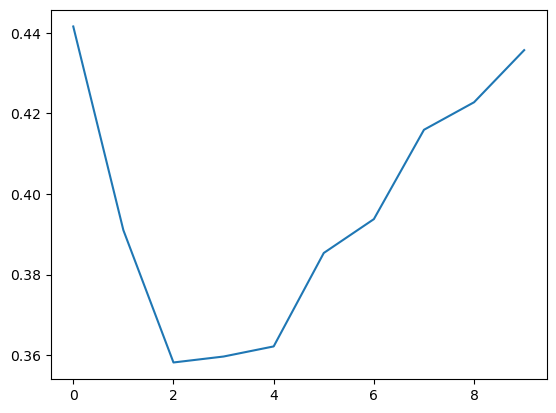

In [59]:
CRPS_Per_leadtime_stacked = np.vstack(CRPS_Per_leadtime)

plt.plot(CRPS_Per_leadtime_stacked.mean(axis = 0))

In [60]:
# Calculate CRPS for both methods
conditional_crps = calculate_overall_crps(all_conditional_ensemble_summaries, all_discharge_summaries, ['total_flow', 'variance',  'autoregression', 'fdc_curve'], unsqueeze = True)
greedy_crps = calculate_overall_crps(all_greedy_ensemble_summaries, all_discharge_summaries, ['total_flow', 'variance', 'autoregression', 'fdc_curve'], unsqueeze = True)


# Create a DataFrame for comparison
comparison_data = {
    'CRPS Metric': ['Total Flow', 'Variance', 'Autoregression', 'FDC Curve'],
    'Greedy Ensemble': [greedy_crps['total_flow'], greedy_crps['variance'],  greedy_crps['autoregression'], greedy_crps['fdc_curve']],
    'Conditional Ensemble': [conditional_crps['total_flow'], conditional_crps['variance'], conditional_crps['autoregression'], conditional_crps['fdc_curve']]

}

# Create DataFrame and format
comparison_df = pd.DataFrame(comparison_data)
pd.set_option('display.precision', 4)  # Set precision to 4 decimal places

# Calculate improvement percentage
comparison_df['Improvement (%)'] = (1 - comparison_df['Conditional Ensemble'] / comparison_df['Greedy Ensemble']) * 100

comparison_df.T

,0,1,2,3
CRPS Metric,Total Flow,Variance,Autoregression,FDC Curve
Greedy Ensemble,2.848,6.5228,0.1714,0.0917
Conditional Ensemble,3.0379,6.6437,0.1657,0.1083
Improvement (%),-6.6663,-1.8536,3.3163,-18.1035


In [16]:
# Generate dispersion calculations on combined data
conditional_dispersion_df = get_dispersion_calculations(all_conditional_ensemble_summaries, all_discharge_summaries, interval = 1/500)
greedy_dispersion_df = get_dispersion_calculations(all_greedy_ensemble_summaries, all_discharge_summaries, interval = 1/500)



/etc/ecmwf/ssd/ssd1/jupyterhub/mokr-jupyterhub/tmpdirs/mokr.40174506/ipykernel_1565796/520765051.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ensemble_stat = torch.tensor(ens_dict[stat_name])  # shape: (num_members, num_batches)


In [17]:
def plot_uniform_qq(dispersion_df, title = 'Q-Q Plot: All Statistics vs Uniform'):
    '''
    Creates Quantile-Quantile plots comparing each statistic's distribution 
    to a Uniform distribution.
    
    Parameters:
    dispersion_df: DataFrame where rows are percentile bins, columns are statistics
                   Values should be percentage of samples in each bin
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    import scipy.stats as stats
    from matplotlib.gridspec import GridSpec
    
    # Get list of statistics (column names)
    statistics = dispersion_df.columns
    n_stats = len(statistics)
    
    
    # For each statistic
    for i, stat in enumerate(statistics):
        # Get the data - convert percentages to proportions
        data = dispersion_df[stat].values / 100.0
        
        # Convert from bin percentages to individual data points
        # We'll replicate each bin value according to its percentage
        bin_edges = np.linspace(0, 1, len(data) + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Generate synthetic data points from bin frequencies
        synthetic_data = []
        for j, bin_center in enumerate(bin_centers):
            # Number of points to generate for this bin
            n_points = int(round(data[j] * 10))
            # Add points at bin center with small jitter
            if n_points > 0:
                jitter = np.random.uniform(-0.1/len(data), 0.1/len(data), n_points)
                synthetic_data.extend([bin_center + j for j in jitter])

        
        # Generate uniform theoretical quantiles
        uniform_quantiles = np.linspace(0, 1, len(synthetic_data))
        
        # Sort our data to get empirical quantiles
        empirical_quantiles = np.sort(synthetic_data)


    # Create a single-plot version with all statistics
    plt.figure(figsize=(10, 10))
    for stat in statistics:
        data = dispersion_df[stat].values / 100.0
        
        # Generate synthetic data points from bin frequencies
        synthetic_data = []
        for j, bin_center in enumerate(bin_centers):
            n_points = int(round(data[j] * 30))
            if n_points > 0:
                jitter = np.random.uniform(-0.1/len(data), 0.1/len(data), n_points)
                synthetic_data.extend([bin_center + j for j in jitter])
        
        # Generate uniform theoretical quantiles
        uniform_quantiles = np.linspace(0, 1, len(synthetic_data))
        
        # Sort our data to get empirical quantiles
        empirical_quantiles = np.sort(synthetic_data)
        
        # Plot this statistic
        plt.scatter(uniform_quantiles, empirical_quantiles, alpha=0.5, label=stat)
        
    # Add diagonal line
    plt.plot([0, 1], [0, 1], 'r--', linewidth=3, label='Uniform')  # Thicker line
    plt.title(f'{title}', fontsize=20)  # Larger title
    plt.xlabel('Uniform Theoretical Quantiles', fontsize=18)
    plt.ylabel('Empirical Quantiles', fontsize=18)
    plt.grid(True, alpha=0.3)
    
    # Make tick marks bigger
    plt.tick_params(axis='both', which='major', width=2, length=8, labelsize=16)
    
    # Make legend bigger with larger markers
    legend = plt.legend(prop={'size': 14}, frameon=True, markerscale=2)

    plt.tight_layout()

    plt.show()

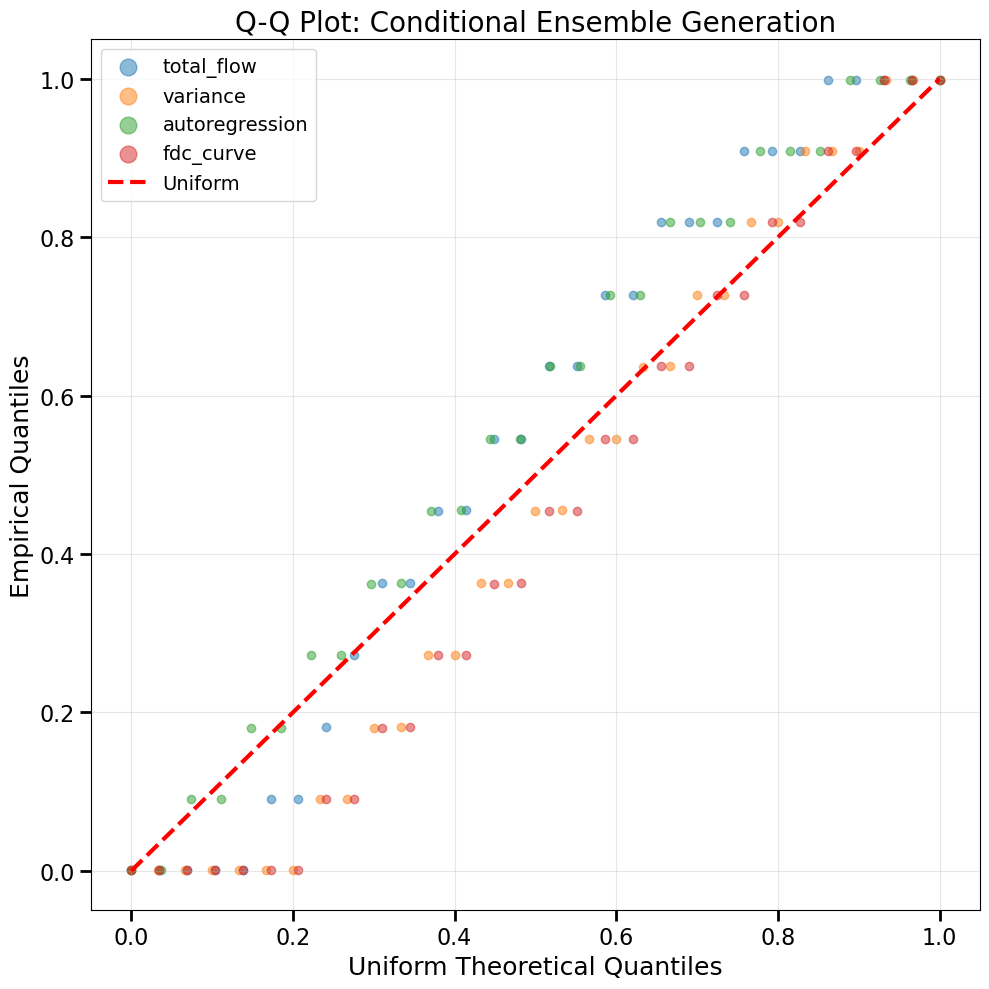

In [18]:
plot_uniform_qq(conditional_dispersion_df, title = 'Q-Q Plot: Conditional Ensemble Generation')

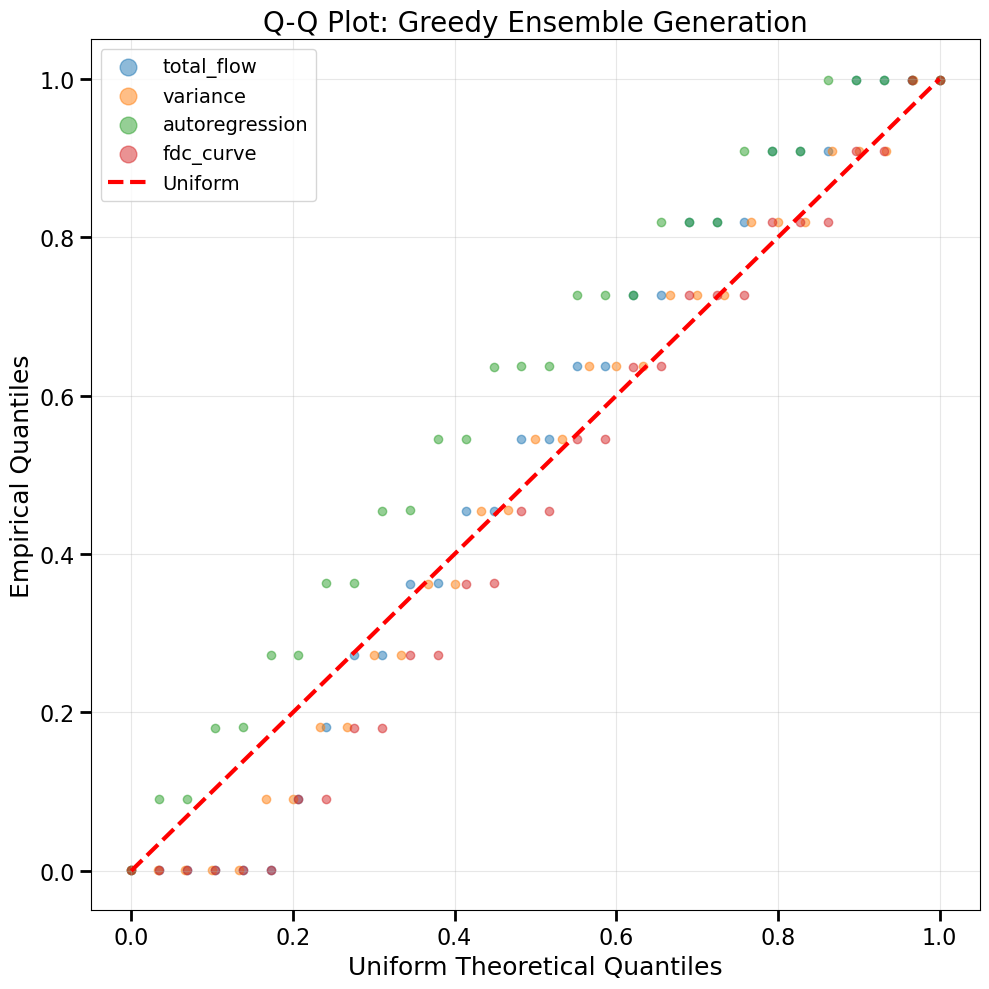

In [19]:
plot_uniform_qq(greedy_dispersion_df, title = 'Q-Q Plot: Greedy Ensemble Generation')

In [20]:
conditional_dispersion_df = get_dispersion_calculations(all_conditional_ensemble_summaries, all_discharge_summaries, interval = 0.1)
greedy_dispersion_df = get_dispersion_calculations(all_greedy_ensemble_summaries, all_discharge_summaries, interval = 0.1)


/etc/ecmwf/ssd/ssd1/jupyterhub/mokr-jupyterhub/tmpdirs/mokr.40174506/ipykernel_1565796/520765051.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ensemble_stat = torch.tensor(ens_dict[stat_name])  # shape: (num_members, num_batches)


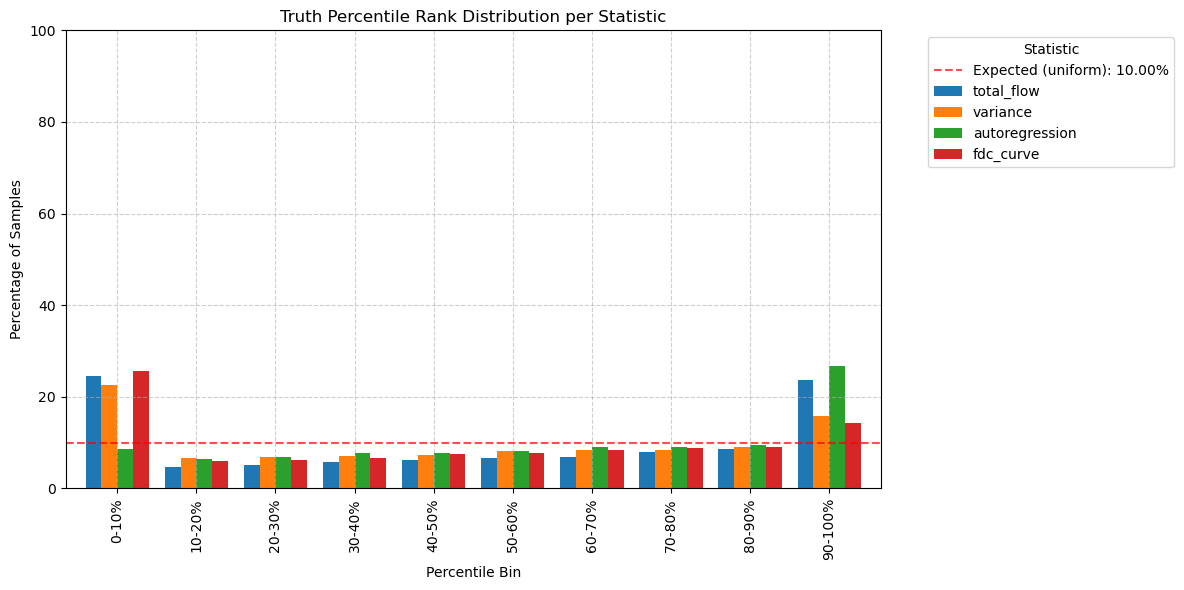

In [21]:
plot_dispersion_histograms(greedy_dispersion_df)

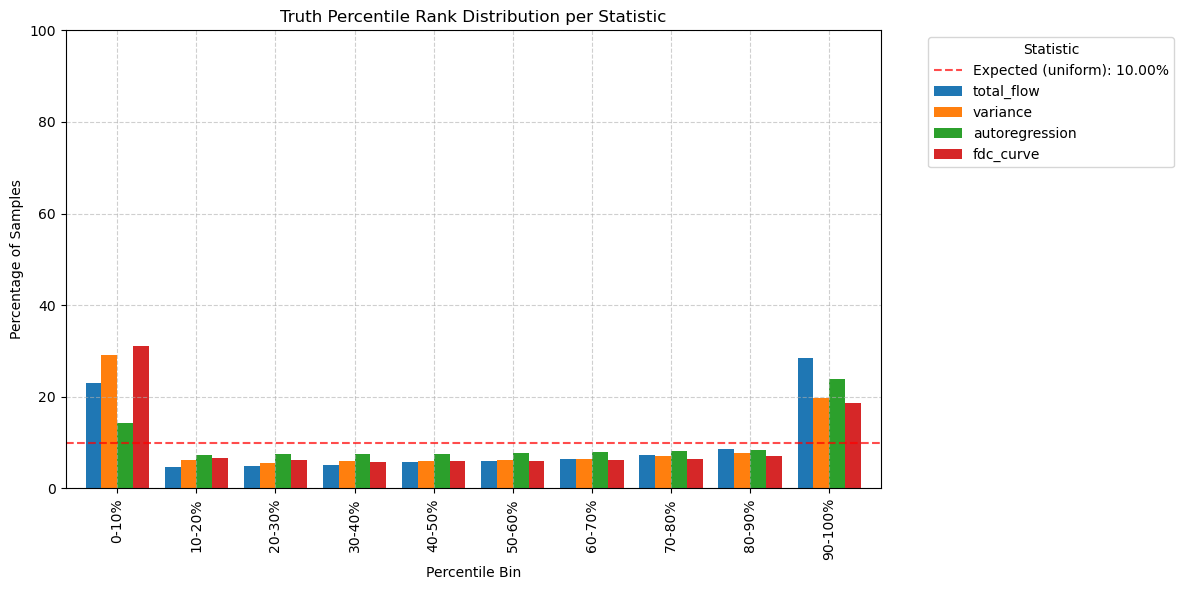

In [22]:
plot_dispersion_histograms(conditional_dispersion_df)

# Training CMAL Model

In [ ]:
hindcast_hidden_size = 32
forecast_hidden_size = 16
handoff_hidden_size = 24
hindcast_input_size = 25
forecast_input_size = 17
hindcast_output_size = 8
forecast_output_size = 12

# G_Model_CMAL1 = ML_functions.Google_Model_Block(hindcast_input_size, forecast_input_size, hindcast_output_size, 4, hindcast_hidden_size, forecast_hidden_size,  handoff_hidden_size, 1, 'cpu', bidirectional = True)
G_Model_CMAL3 = ML_functions.Google_Model_Block(hindcast_input_size, forecast_input_size, hindcast_output_size, forecast_output_size, hindcast_hidden_size, forecast_hidden_size,  handoff_hidden_size, 1, 'cpu', bidirectional = False, eval_dropout = False)

optimizer = optim.Adam(G_Model_CMAL3.parameters(), lr= 1e-3)



In [ ]:
# Loss is geting negative, why??
# G_Model_CMAL3 = ML_functions.Google_Model_Block(hindcast_input_size, forecast_input_size, hindcast_output_size, forecast_output_size, hindcast_hidden_size, forecast_hidden_size,  handoff_hidden_size, 1, 'cpu', bidirectional = False)

i = 0
size = 1000
should_break = False
optimizer = optim.Adam(G_Model_CMAL3.parameters(), lr= 1e-3)
criterion = ML_functions.CMALLoss()
# criterion = CMALLoss()
# criterion = CRPSLoss(num_integration_points=100)
G_Model_CMAL3.train(True)

average_loss = 0
all_sample_losses = []  

epochs = 1
for epoch in range(epochs):
    epoch_sample_losses = [] 
    for Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_values, end_prediction_date, basin_idx in Training_Dataloader:
        batch_sample_losses = []
        ground_truth = {}
        ground_truth['y'] = Y_values
        
        mask = Fore_X_Chunk_Torch[:,:,-1] != 1
        Y_values_masked = Y_values.clone()
        Y_values_masked[~mask] = float('nan')  
        ground_truth['y'] = Y_values_masked

        i = i+1
        
        predictions = G_Model_CMAL3(Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch.to(torch.float32))[1].squeeze()
        predictions = ML_functions.transform_CMAL_parameters_multi(predictions)
        loss = 0

        for sample_idx in range(len(Y_values)):
            for day in range(len(predictions)):
                ground_truth = {'y': Y_values_masked[:, day]}
                num_nans = torch.isnan(Y_values_masked[:, day]).sum()
                # ground_truth = ground_truth['y']
                if not torch.isnan(Y_values_masked[:, day]).all():
                    prediction = {}
                    prediction = {
                        'mu': predictions[:, day, ::4],   # mu is at indices 0 mod 4
                        'b': predictions[:, day, 1::4],   # b is at indices 1 mod 4 (ensure positive)
                        'tau': predictions[:, day, 2::4], # tau is at indices 2 mod 4 (ensure 0-1)
                        'pi': predictions[:, day, 3::4],  # pi is at indices 3 mod 4
                    }
    
                    day_loss = criterion(prediction, ground_truth)
                    loss += day_loss
                    batch_sample_losses.append({
                        'basin_idx': basin_idx[sample_idx].item() if torch.is_tensor(basin_idx) else basin_idx[sample_idx],
                        'day': day,
                        'end_prediction_date': end_prediction_date[sample_idx] if isinstance(end_prediction_date, list) else end_prediction_date[sample_idx],
                        'loss': day_loss.item(),
                        'num_nans': num_nans
                    })
        
                if not torch.isnan(ground_truth['y']).all():
                    if torch.isnan(criterion(prediction, ground_truth)):
                        print('prediction date and basin are', end_prediction_date, basin_idx, 'Prediction is', prediction)
                        should_break = True
                        break
        epoch_sample_losses.extend(batch_sample_losses)
        if should_break:
            break
        
                

        
      
        average_loss += loss
        
        if (i+1) % size == 0:
            print(i)
            print('Average loss is', average_loss/size)
            # average_loss.backward()
            # optimizer.step()
            # optimizer.zero_grad()
            average_loss = 0

        for name, param in G_Model_CMAL3.named_parameters():
            if param.requires_grad and torch.isnan(param).any():
                break
    if should_break:
        break
    print('Average loss is', average_loss/size)
    average_loss = 0


# Finding Weird Basins

In [ ]:
# losses_df = pd.DataFrame(epoch_sample_losses)
losses_df[losses_df['loss'] > 15]

In [ ]:
Discharge = pd.read_csv('/home/mokr/Loss_Functions_Paper/Scaled/discharge_scaled.csv')
Discharge = Discharge.set_index('date')

In [ ]:
test_losses_df = pd.DataFrame(epoch_sample_losses)
test_losses_df[test_losses_df['loss'] > 15]['basin_idx'].to_list()

In [ ]:
ERA5_zarr_path = '/perm/mokr/Caravans_MultiMet/ERA5_LAND/timeseries.zarr'
ERA5_Land = xr.open_zarr(store=ERA5_zarr_path, chunks= None)


In [ ]:
discharge_2016_2019 = Discharge.loc["2016-01-01":"2019-12-31"]

# Compute mean discharge for each basin
mean_discharge = discharge_2016_2019.mean()


precip_2016_2019 = ERA5_Land['era5land_total_precipitation'].sel(date=slice("2016-01-01", "2018-12-31"))

# Mean precipitation per basin
mean_precip = precip_2016_2019.mean(dim="date").to_series()

In [ ]:
df_plot = pd.DataFrame({
    'mean_discharge': mean_discharge,
    'mean_precip': mean_precip
}).dropna()

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_plot['mean_precip'], df_plot['mean_discharge'])
plt.xlabel("Mean Precipitation (2016–2019)")
plt.ylabel("Mean Discharge (2016–2019)")
plt.title("Basin-wise Mean Precip vs Discharge")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
basin_name = 'hysets_05QA002'

# Extract precipitation data for the selected basin
basin_precip = ERA5_Land['era5land_total_precipitation'].sel(basin=basin_name)

# Extract discharge data for the selected basin
basin_discharge = Discharge[basin_name]

basin_discharge_ts = basin_discharge

basin_precip_ts = basin_precip.to_series()
basin_precip_ts.index = pd.to_datetime(basin_precip_ts.index)
basin_discharge_ts.index = pd.to_datetime(basin_discharge_ts.index)

# Get the intersection of the indices
start_date = "2016-01-01"
end_date = "2018-12-31"
common_index = basin_precip_ts.index.intersection(basin_discharge_ts.index)
common_index = common_index[(common_index >= start_date) & (common_index <= end_date)]

# (Optional) Subset the dataframes to just the common index
basin_precip_ts_common = basin_precip_ts.loc[common_index]
basin_discharge_ts_common = basin_discharge_ts.loc[common_index]
plt.figure(figsize=(12, 6))

# Create two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot precipitation
ax1.plot(basin_precip_ts_common.index, basin_precip_ts_common, 'b-', label='Precipitation')
ax1.set_xlabel('Date')
ax1.set_ylabel('Precipitation', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot discharge
ax2.plot(basin_discharge_ts_common.index, basin_discharge_ts_common.values, 'r-', label='Discharge')
ax2.set_ylabel('Discharge', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend
plt.title(f'Precipitation and Discharge for {basin_name}')
fig.tight_layout()

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

# Optional: If you want to create a scatter plot to see the relationship
plt.figure(figsize=(10, 6))
plt.scatter(basin_precip_ts_common.values, basin_discharge_ts_common.values, alpha=0.5)
plt.xlabel('Precipitation')
plt.ylabel('Discharge')
plt.title(f'Precipitation vs Discharge for {basin_name}')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
corr_matrix = np.corrcoef(basin_precip_ts_common.values.flatten(), 
                          basin_discharge_ts_common.values.flatten())
correlation = corr_matrix[0, 1]
print("Correlation:", correlation)

In [ ]:
basin_discharge_ts.index #.index #.intersection(basin_discharge_ts.index)

In [ ]:
Max_Discharges = Discharge.select_dtypes(include='number').max() #[lambda x: x > 50]
Mean_Discharges = Discharge.select_dtypes(include='number').mean() #[lambda x: x > 50]
Discharge_Diff = abs(Max_Discharges/(Mean_Discharges+1))

In [ ]:
Discharge_Diff[lambda x: abs(x) > 60]#.index.tolist()


In [ ]:
Max_Discharges[lambda x: x > 100]#.index.tolist()


In [ ]:
Mean_Discharges[lambda x: x > 2]#.index.tolist()


In [ ]:
plt.figure(figsize=(20, 6))
plt.hist(Discharge_Diff, bins=8000)
# Add labels and title
plt.xlabel('Normalized Max Specific Discharge')
plt.ylabel('Frequency')
plt.title('Distribution of Max Specific Discharge across Catchments')
# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
plt.hist(Max_Discharges, bins=8000)
# Add labels and title
plt.xlabel('Normalized Max Specific Discharge')
plt.ylabel('Frequency')
plt.title('Distribution of Max Specific Discharge across Catchments')
# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
plt.hist(Mean_Discharges, bins=8000)
# Add labels and title
plt.xlabel('Normalized Average Annual Specific Discharge')
plt.ylabel('Frequency')
plt.title('Distribution of Specific Discharge across Catchments')
plt.xscale('log')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
basin_ids = [
    'hysets_0208735012',
    'hysets_08HB086',
    'hysets_08MH141',
    'hysets_08HE009',
    'hysets_12036000',
    'hysets_05QA002'
]

# Make sure 'date' is datetime
Discharge['date'] = pd.to_datetime(Discharge['date'])

# Set up the figure
plt.figure(figsize=(14, 6))

# Plot each basin's discharge
for basin in basin_ids:
    if basin in Discharge.columns:
        plt.plot(Discharge['date'], Discharge[basin], label=basin)
    else:
        print(f"Warning: {basin} not found in Discharge columns.")

plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Discharge Time Series for Selected Basins')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
import geopandas as gpd

basin_ids = [
    'hysets_0208735012',
    'hysets_08HB086',
    'hysets_08MH141',
    'hysets_08HE009',
    'hysets_12036000',
    'hysets_05QA002'
]


basin_ids = ['hysets_03431300',
 'camelsbr_73690001',
 'hysets_07019000',
 'hysets_02209000',
 'hysets_02HJ005',
 'hysets_01411000',
 'hysets_05451700',
 'hysets_02207400',
 'hysets_08023080',
 'hysets_05QA002',
 'hysets_07010086',
 'hysets_02HD012']

Data_Sources = set(path.split('_')[0] for path in basin_ids)
Basins = basin_ids

Folder_Data_Sources = ['grdc' if source == 'GRDC' else source for source in Data_Sources]

Geopandas_sources = {}
for data_source in set(Folder_Data_Sources):
    Geopandas_sources[data_source] = gpd.read_file(f'/ec/res4/scratch/ecm7072/caravan/shapefiles/{data_source}/{data_source}_basin_shapes.shp')

Extra_Metadata = pd.read_csv(f'/ec/res4/scratch/ecm7072/caravan/attributes/hysets/attributes_other_hysets.csv')

In [ ]:
basin_ids = [
    'hysets_0208735012',
    'hysets_08HB086',
    'hysets_08MH141',
    'hysets_08HE009',
    'hysets_12036000',
    'hysets_05QA002'
]

basin_ids = ['hysets_03431300',
 # 'camelsbr_73690001',
 'hysets_07019000',
 'hysets_02209000',
 'hysets_02HJ005',
 'hysets_01411000',
 'hysets_05451700',
 'hysets_02207400',
 'hysets_08023080',
 'hysets_05QA002',
 'hysets_07010086',
 'hysets_02HD012',
 'hysets_08072730'
            ]

Basin_metadata = Extra_Metadata[Extra_Metadata['gauge_id'].isin(basin_ids)]
Basin_shapefiles = Geopandas_sources[data_source][Geopandas_sources[data_source]['gauge_id'].isin(basin_ids)]
Basin_data = pd.merge(Basin_shapefiles, Basin_metadata, on='gauge_id', how='outer')

In [ ]:
Basin_data

In [ ]:
Basins.plot()

In [ ]:
def plot_high_loss_samples(losses_df, Discharge, loss_threshold=15):
    """
    Creates plots for each high-loss sample showing discharge data around the prediction date.
    
    Args:
        losses_df: DataFrame containing sample losses and metadata
        Discharge: DataFrame containing discharge data by date and basin
        loss_threshold: Threshold to identify high-loss samples
    """
    # Filter high-loss samples
    high_loss_df = losses_df[losses_df['loss'] > loss_threshold]
    
    # Check if we have any high-loss samples
    if high_loss_df.empty:
        print("No samples found with loss > {loss_threshold}")
        return
        
    print(f"Found {len(high_loss_df)} samples with loss > {loss_threshold}")
    
    # Ensure discharge date is datetime
    Discharge['date'] = pd.to_datetime(Discharge['date'])
    
    # For each high-loss sample
    for idx, row in high_loss_df.iterrows():
        try:
            basin_id = row['basin_idx']
            end_date = pd.to_datetime(row['end_prediction_date'])
            start_date = end_date - pd.Timedelta(days=10)
            
            # Filter discharge data
            mask = (Discharge['date'] >= start_date) & (Discharge['date'] <= end_date)
            subset = Discharge.loc[mask]
            
            # Check if we have data for this basin
            if basin_id not in subset.columns:
                print(f"Basin {basin_id} not found in discharge data")
                continue
                
            # Create plot
            plt.figure(figsize=(10, 5))
            plt.plot(subset['date'], subset[basin_id], marker='o')
            plt.title(f"Discharge at Station {basin_id} (Loss: {row['loss']:.2f})")
            plt.xlabel('Date')
            plt.ylabel('Discharge')
            plt.xticks(rotation=45)
            plt.grid(True)
            
            # Add vertical line at the end prediction date
            plt.axvline(x=end_date, color='r', linestyle='--', 
                       label=f'Prediction Date: {end_date.strftime("%Y-%m-%d")}')
            
            # Add annotation about the loss
            plt.annotate(f"Loss: {row['loss']:.2f}\nEpoch: {row['epoch']}\nDay: {row['day']}",
                        xy=(0.02, 0.95), xycoords='axes fraction',
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
            
            plt.legend()
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error processing row {idx}: {e}")

plot_high_loss_samples(losses_df, Discharge, loss_threshold=15)

In [ ]:
# Plot histogram of losses
plt.figure(figsize=(20, 6))
plt.hist(losses_df['loss'], bins=10000)

# Add labels and title
plt.xlabel('Distribution of loss per observation')
plt.ylabel('Frequency')
plt.title('Loss')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
def crps_loss(param_predictions, observations, num_integration_points=100):
    """
    Calculate CRPS loss for a batch of predictions with asymmetric Laplacian distribution
    
    Args:
        param_predictions (dict): Dictionary with distribution parameters
                                  'mu': location parameter
                                  'b': scale parameter
                                  'tau': asymmetry parameter (0 < tau < 1)
        observations (torch.Tensor): Observed values (shape: (batch_size,)
        num_integration_points (int): Number of points to use for numerical integration
        
    Returns:
        torch.Tensor: CRPS loss (shape: (batch_size,))
    """

    
    batch_size = observations.shape[0]
    
    # Extract parameters for asymmetric Laplacian
    m = param_predictions['mu']  # (batch_size, num_components)
    b = param_predictions['b']   # (batch_size, num_components)
    t = param_predictions['tau'] # (batch_size, num_components)
    pi = param_predictions['pi'] # (batch_size, num_components)

    # Ensure pi sums to 1 along component dimension
    pi = pi / torch.sum(pi, dim=1, keepdim=True)
    
    # Calculate proper mean and standard deviation for each component
    # Mean = mu + b * (1 - 2*tau) / (tau * (1 - tau))
    component_means = m + b * (1 - 2*t) / (t * (1 - t))
    
    # Variance = b^2 * (1 - 2*tau + 2*tau^2) / (tau^2 * (1 - tau)^2)
    component_vars = b**2 * (1 - 2*t + 2*t**2) / (t**2 * (1 - t)**2)
    component_stds = torch.sqrt(component_vars)
    
    # Calculate mixture mean (weighted average of component means)
    mixture_mean = torch.sum(pi * component_means, dim=1)  # (batch_size,)
    
    # Calculate mixture variance: E[(X-μ)²] = Σπ_i[(μ_i-μ)² + σ_i²]
    # First term: variance due to component means differing from mixture mean
    mean_variance = torch.sum(pi * (component_means - mixture_mean.unsqueeze(1))**2, dim=1)
    # Second term: weighted average of component variances
    avg_variance = torch.sum(pi * component_vars, dim=1)
    # Total variance
    mixture_var = mean_variance + avg_variance
    mixture_std = torch.sqrt(mixture_var)
    
    # For batch calculation, we'll use average of mixture means and standard deviations
    mean_avg = torch.mean(mixture_mean)
    std_avg = torch.mean(mixture_std)
    
    # Use mean±4*std 
    lower_bound = (mean_avg - 4 * std_avg).item()
    upper_bound = (mean_avg + 4 * std_avg).item()
    
    # Create integration points
    integration_points = torch.linspace(lower_bound, upper_bound, num_integration_points)
    integration_points = integration_points.repeat(batch_size, 1)  # (batch_size, num_integration_points)
    
    # Compute CDF at integration points
    cdf_values = compute_CDF(integration_points, param_predictions)  # (batch_size, num_integration_points)
    
    # Calculate heaviside step function (1 if integration_point >= observation, 0 otherwise)
    observations_expanded = observations.unsqueeze(1).expand_as(integration_points)
    heaviside = (integration_points >= observations_expanded).float()
    
    # Calculate squared difference
    squared_diff = (cdf_values - heaviside) ** 2
    
    # Numerical integration using trapezoidal rule
    dx = (upper_bound - lower_bound) / (num_integration_points - 1)
    integrated_values = 0.5 * dx * (squared_diff[:, :-1] + squared_diff[:, 1:])
    crps = torch.sum(integrated_values, dim=1)  # Sum over integration points
    
    return crps

In [ ]:
def compute_CDF(integration_points, param_predictions):
    """
    Compute CDF of predicted distribution
    
    Args:
        integration_points (torch.Tensor): Points at which to evaluate the CDF (shape: (batch_size, num_points))
        param_predictions (dict): Dictionary with 'mu', 'b', 'tau', 'pi' arrays
            mu (torch.Tensor): Mean parameters (shape: (batch_size, num_components))
            b (torch.Tensor): Scale parameters (shape: (batch_size, num_components))
            tau (torch.Tensor): Shape parameters (shape: (batch_size, num_components))
            pi (torch.Tensor): Mixture weights (shape: (batch_size, num_components))
    
    Returns:
        torch.Tensor: CDF values at the points y (shape: (batch_size, num_points))
    """
    m = param_predictions['mu']  # (batch_size, num_components)
    b = param_predictions['b']   # (batch_size, num_components)
    t = param_predictions['tau'] # (batch_size, num_components)
    pi = param_predictions['pi'] # (batch_size, num_components)
    
    # Ensure pi sums to 1 along component dimension
    pi = pi / torch.sum(pi, dim=1, keepdim=True)
    
    # Expand dimensions for broadcasting
    # y: (batch_size, num_points, 1)
    # m: (batch_size, 1, num_components)
    integration_points_expanded = integration_points.unsqueeze(-1)  
    m_expanded = m.unsqueeze(1)
    b_expanded = b.unsqueeze(1)
    t_expanded = t.unsqueeze(1)
    pi_expanded = pi.unsqueeze(1)
    
    # Calculate normalized error
    error = integration_points_expanded - m_expanded  # (batch_size, num_points, num_components)
    
    # Calculate CDF value based on error sign
    negative_mask = error > 0
    positive_mask = ~negative_mask
    
    # Initialize CDF tensor
    component_cdfs = torch.zeros_like(error)
    
    # Handle positive errors
    if torch.any(positive_mask):
        component_cdfs[positive_mask] = t_expanded.expand_as(error)[positive_mask] * torch.exp(
            (1 - t_expanded.expand_as(error)[positive_mask]) * error[positive_mask] / b_expanded.expand_as(error)[positive_mask]
        )
    
    # Handle negative errors
    if torch.any(negative_mask):
        component_cdfs[negative_mask] = 1 - (1 - t_expanded.expand_as(error)[negative_mask]) * torch.exp(
            (-t_expanded.expand_as(error)[negative_mask]) * error[negative_mask] / b_expanded.expand_as(error)[negative_mask]
        )
    
    # Apply mixture weights and sum over components
    cdf_values = torch.sum(pi_expanded.expand_as(component_cdfs) * component_cdfs, dim=2)
    
    return cdf_values





In [ ]:
import torch.nn as nn

In [ ]:
class CRPSLoss(nn.Module):
    """
    PyTorch module implementing CRPS loss for a mixture of asymmetric Laplacian distributions
    
    This loss can be used directly in standard PyTorch training loops.
    """
    def __init__(self, num_integration_points=100):
        """
        Initialize the CRPS loss function
        
        Args:
            num_integration_points (int): Number of points to use for numerical integration
        """
        super(CRPSLoss, self).__init__()
        self.num_integration_points = num_integration_points
    def forward(self, param_predictions, observations):
        """
        Calculate CRPS loss for a batch of predictions
        
        Args:
            param_predictions (dict): Dictionary with distribution parameters
                                     'mu': location parameters (batch_size, num_components)
                                     'b': scale parameters (batch_size, num_components)
                                     'tau': asymmetry parameters (batch_size, num_components)
                                     'pi': mixture weights (batch_size, num_components)
            observations (torch.Tensor): Observed values (shape: (batch_size,))
            
        Returns:
            torch.Tensor: CRPS loss (shape: (batch_size,))
        """
        batch_size = observations.shape[0]
        
        # Extract parameters for asymmetric Laplacian mixture
        m = param_predictions['mu']  # (batch_size, num_components)
        b = param_predictions['b']   # (batch_size, num_components)
        t = param_predictions['tau'] # (batch_size, num_components)
        pi = param_predictions['pi'] # (batch_size, num_components)
        
        # Ensure pi sums to 1 along component dimension
        pi = pi / torch.sum(pi, dim=1, keepdim=True)
        
        # Calculate proper mean and standard deviation for each component
        # Mean = mu + b * (1 - 2*tau) / (tau * (1 - tau))
        component_means = m + b * (1 - 2*t) / (t * (1 - t))
        
        # Variance = b^2 * (1 - 2*tau + 2*tau^2) / (tau^2 * (1 - tau)^2)
        component_vars = b**2 * (1 - 2*t + 2*t**2) / (t**2 * (1 - t)**2)
        component_stds = torch.sqrt(component_vars)
        
        # Calculate mixture mean (weighted average of component means)
        mixture_mean = torch.sum(pi * component_means, dim=1)  # (batch_size,)
        
        # Calculate mixture variance: E[(X-μ)²] = Σπ_i[(μ_i-μ)² + σ_i²]
        mean_variance = torch.sum(pi * (component_means - mixture_mean.unsqueeze(1))**2, dim=1)
        avg_variance = torch.sum(pi * component_vars, dim=1)
        mixture_var = mean_variance + avg_variance
        mixture_std = torch.sqrt(mixture_var)
        
        mean_avg = torch.mean(mixture_mean)
        std_avg = torch.mean(mixture_std)
        
        # Use mean±5*std 
        lower_bound = (mean_avg - 2 * std_avg).item()
        upper_bound = (mean_avg + 4 * std_avg).item()
        
        # Create integration points
        integration_points = torch.linspace(lower_bound, upper_bound, self.num_integration_points, device=observations.device)
        integration_points = integration_points.repeat(batch_size, 1)  # (batch_size, num_integration_points)
        
        # Compute CDF at integration points
        cdf_values = self._compute_mixture_cdf(integration_points, param_predictions)
        
        # Calculate heaviside step function (1 if integration_point >= observation, 0 otherwise)
        observations_expanded = observations.unsqueeze(1).expand_as(integration_points)
        heaviside = (integration_points >= observations_expanded).float()
        
        # Calculate squared difference
        squared_diff = (cdf_values - heaviside) ** 2
        
        # Numerical integration using trapezoidal rule
        dx = (upper_bound - lower_bound) / (self.num_integration_points - 1)
        integrated_values = 0.5 * dx * (squared_diff[:, :-1] + squared_diff[:, 1:])
        crps = torch.sum(integrated_values, dim=1)  # Sum over integration points
        crps = torch.sum(crps)
        return crps
    
    def _compute_mixture_cdf(self, integration_points, param_predictions):
        """
        Compute CDF of a mixture of asymmetric Laplacian distributions
        
        Args:
            x (torch.Tensor): Points to evaluate CDF at (shape: (batch_size, num_points))
            params (dict): Dictionary with distribution parameters
        
        Returns:
            torch.Tensor: CDF values (shape: (batch_size, num_points))
        """
        # Get parameters
        m = param_predictions['mu']  # (batch_size, num_components)
        b = param_predictions['b']   # (batch_size, num_components)
        t = param_predictions['tau'] # (batch_size, num_components)
        pi = param_predictions['pi'] # (batch_size, num_components)
        
        # Ensure pi sums to 1 along component dimension
        pi = pi / torch.sum(pi, dim=1, keepdim=True)
        
        # Expand dimensions for broadcasting
        # y: (batch_size, num_points, 1)
        # m: (batch_size, 1, num_components)
        integration_points_expanded = integration_points.unsqueeze(-1)  
        m_expanded = m.unsqueeze(1)
        b_expanded = b.unsqueeze(1)
        t_expanded = t.unsqueeze(1)
        pi_expanded = pi.unsqueeze(1)
        
        # Calculate normalized error
        error = integration_points_expanded - m_expanded  # (batch_size, num_points, num_components)
        
        # Calculate CDF value based on error sign
        greater_mask = error > 0
        less_mask = ~greater_mask
        
        # Initialize CDF tensor
        component_cdfs = torch.zeros_like(error)
        
        # Handle positive errors
        if torch.any(less_mask):
            component_cdfs[less_mask] = t_expanded.expand_as(error)[less_mask] * torch.exp(
                (1 - t_expanded.expand_as(error)[less_mask]) * error[less_mask] / b_expanded.expand_as(error)[less_mask]
            )
        
        # Handle negative errors
        if torch.any(greater_mask):
            component_cdfs[greater_mask] = 1 - (1 - t_expanded.expand_as(error)[greater_mask]) * torch.exp(
                (-t_expanded.expand_as(error)[greater_mask]) * error[greater_mask] / b_expanded.expand_as(error)[greater_mask]
            )
        
        # Apply mixture weights and sum over components
        cdf_values = torch.sum(pi_expanded.expand_as(component_cdfs) * component_cdfs, dim=2)
        
        return cdf_values


In [ ]:
class CMALLoss(nn.Module):
    # Negative log-likelihood for a single asymmetric Laplacian distribution
    # Taken from Neural Hydrology, uses Alternative parameterization for Bayesian quantile regression (wikipedia)
    def __init__(self, eps=1e-8):
        super(CMALLoss, self).__init__()
        self.eps = eps  # Small constant for numerical stability

    def forward(self, prediction: dict[str, torch.Tensor], ground_truth: dict[str, torch.Tensor]):
        mask = ~torch.isnan(ground_truth['y'])
        
        # Apply mask to all relevant tensors
        y = ground_truth['y'][mask]
        m = prediction['mu'][mask]
        b = prediction['b'][mask]
        t = prediction['tau'][mask]
        p = prediction['pi'][mask]
        error = y.unsqueeze(-1) - m
        log_like = (torch.log(t) + 
                    torch.log(1.0 - t) - 
                    torch.log(b  + self.eps) - 
                    torch.max(t * error, (t - 1.0) * error) / b)
        
        log_weights = torch.log(p + self.eps)  # Prevent log(0) issues
    
        result = torch.logsumexp(log_weights + log_like, dim=-1)  # Use dim=-1 for flexibility
        
        result = -torch.mean(result, dim=-1)
        return result

In [ ]:
# G_Model = torch.load('/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Models/G_Model_Deterministic.pth')

# save_path = '/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Models/G_Model_CMAL_Binary_GPU_28_03.pth'
# torch.save(G_Model_CMAL3, save_path)


# Plotting Generated Ensembles

In [ ]:
def plot_multiple_trajectories(trajectories_list, titles=None):
    """
    Plot multiple sets of generated trajectories in separate subplots.
    
    Args:
        trajectories_list (list of np.ndarray): List of trajectory arrays with shape (num_trajectories, num_steps)
        titles (list of str, optional): Titles for each subplot
    """
    num_plots = len(trajectories_list)
    fig, axes = plt.subplots(nrows=num_plots, figsize=(10, 5 * num_plots), sharex=True)

    # Ensure axes is iterable if there's only one plot
    if num_plots == 1:
        axes = [axes]  

    for i, (trajectories, ax) in enumerate(zip(trajectories_list, axes)):
        num_trajectories, num_steps = trajectories.shape
        time_steps = np.arange(1, num_steps + 1)

        # Plot each trajectory separately within its subplot
        for j in range(num_trajectories):
            ax.plot(time_steps, trajectories[j, :], alpha=0.3, label=f'Trajectory {j+1}')

        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Value")
        ax.set_xticks(np.linspace(1, min(10, num_steps), num=10, dtype=int))  # Set x-ticks from 1 to 10
        ax.grid(True, linestyle="--", alpha=0.6)
        # ax.legend(loc="best", fontsize="small", ncol=2)
        
        if titles and i < len(titles):
            ax.set_title(titles[i])

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_ensemble_predictions(ensemble_predictions):
    """
    Scatter plot of ensemble predictions per day with no connecting lines.

    Args:
        ensemble_predictions (np.ndarray): Ensemble predictions with shape (num_members, num_steps).
    """
    num_members, num_days = ensemble_predictions.shape
    time_steps = np.arange(1, num_days + 1)  # X-axis values (days 1 to 10)

    plt.figure(figsize=(10, 5))
    
    for i in range(num_days):
        plt.scatter([time_steps[i]] * num_members, ensemble_predictions[:, i], color = 'blue', alpha=0.6, label=f'Day {i+1}' if i == 0 else None)

    plt.xlabel("Day")
    plt.ylabel("Predicted Value")
    plt.title("Ensemble Predictions Per Day")
    plt.xticks(time_steps)  # Ensure xticks go from 1 to 10
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    
    plt.show()

# plot_ensemble_predictions(ensemble_predictions)

In [ ]:
num_members = 30
ensemble_predictions = get_random_ensembles(
    model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, 
    num_members= num_members)

# Generate random trajectories
trajectories = generate_random_trajectories(
    ensemble_predictions)


plot_trajectories(trajectories)


In [ ]:
# Generate random trajectories
trajectories = generate_random_trajectories(
    ensemble_predictions)


plot_trajectories(trajectories)


In [ ]:
plot_multiple_trajectories([generate_random_trajectories(ensemble_predictions), generate_random_trajectories(ensemble_predictions), generate_random_trajectories(ensemble_predictions), generate_random_trajectories(ensemble_predictions)], titles=["Set 1", "Set 2", "Set 3", "Set 4"])


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def plot_ensemble_predictions(ensemble_predictions, true_discharge=None, title='Ensemble Predictions', plot_type='both', unnormalize=True, scaler_path='/home/mokr/Loss_Functions_Paper/Scalers/discharge_caravan_scalers.joblib'):
    """
    Plot ensemble predictions with multiple visualization options.
    
    Args:
        ensemble_predictions (torch.Tensor): Tensor of ensemble predictions
        true_discharge (torch.Tensor, optional): True discharge values for comparison
        title (str, optional): Plot title
        plot_type (str, optional): Type of plot to generate
        normalize (bool, optional): Whether to normalize using the scaler
        scaler_path (str, optional): Path to the joblib scaler file
    """
    # Normalize if requested
    if unnormalize:
        ensemble_predictions, true_discharge = load_and_unnormalize(
            ensemble_predictions, 
            true_discharge, 
            scaler_path
        )
        
    # Convert to numpy if tensor
    if isinstance(ensemble_predictions, torch.Tensor):
        ensemble_predictions = ensemble_predictions.numpy()
    
    # Convert true_discharge to numpy if tensor
    if true_discharge is not None and isinstance(true_discharge, torch.Tensor):
        true_discharge = true_discharge.numpy().squeeze()
    
    # Validate plot_type
    valid_plot_types = ['ensemble', 'violin', 'both']
    if plot_type not in valid_plot_types:
        raise ValueError(f"plot_type must be one of {valid_plot_types}")
    
    # Create subplots based on plot type
    if plot_type == 'ensemble':
        fig, ax = plt.subplots(figsize=(14, 7))
        _plot_ensemble(ax, ensemble_predictions, true_discharge, title)
    elif plot_type == 'violin':
        fig, ax = plt.subplots(figsize=(14, 7))
        _plot_violin(ax, ensemble_predictions, true_discharge, title)
    else:  # both
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
        _plot_ensemble(ax1, ensemble_predictions, true_discharge, f'{title} - Ensemble')
        _plot_violin(ax2, ensemble_predictions, true_discharge, f'{title} - Violin Plot')
    
    plt.tight_layout()
    plt.show()

def _plot_ensemble(ax, ensemble_predictions, true_discharge=None, title=None):
    """
    Plot ensemble predictions on a given axis.
    
    Args:
        ax (matplotlib.axes.Axes): Axis to plot on
        ensemble_predictions (np.ndarray): Ensemble predictions
        true_discharge (np.ndarray, optional): True discharge values
        title (str, optional): Plot title
    """
    # Calculate statistics
    mean_predictions = np.mean(ensemble_predictions, axis=0)
    lower_percentile = np.percentile(ensemble_predictions, 10, axis=0)
    upper_percentile = np.percentile(ensemble_predictions, 90, axis=0)
    
    # Plot ensemble members (light blue, low opacity)
    for prediction in ensemble_predictions:
        ax.plot(prediction, color='blue', alpha=0.2, linewidth=1)
    
    # Plot mean prediction
    ax.plot(mean_predictions, color='blue', linewidth=2, label='Ensemble Mean')
    
    # Plot confidence interval
    ax.fill_between(range(len(mean_predictions)), 
                    lower_percentile, 
                    upper_percentile, 
                    color='grey', 
                    alpha=0.2, 
                    label='80% Confidence Interval')
    
    # Plot true_discharge if provided
    if true_discharge is not None:
        ax.plot(true_discharge, color='black', linewidth=2, label='Observations')

    if true_discharge is not None:
        ax.legend()
        
    ax.set_title(title or 'Ensemble Predictions')
    ax.set_xlabel('Lead Time')
    ax.set_ylabel('Normalised River Discharge')
    ax.legend()

def _plot_violin(ax, ensemble_predictions, true_discharge=None, title=None):
    """
    Create violin plot of ensemble predictions on a given axis.
    
    Args:
        ax (matplotlib.axes.Axes): Axis to plot on
        ensemble_predictions (np.ndarray): Ensemble predictions
        true_discharge (np.ndarray, optional): True discharge values
        title (str, optional): Plot title
    """
    # Prepare data for violin plot
    # Transpose to get distribution for each time step
    ensemble_T = ensemble_predictions
    
    # Create violin plot
    sns.violinplot(data=ensemble_T, ax=ax, color= 'lightcoral', cut=0, log_scale = False)
    
    # Plot true discharge if provided
    if true_discharge is not None:
        ax.plot(range(len(true_discharge)), true_discharge, 
                color='black', linewidth=2, label='Observations', marker='o')
    
    ax.set_title(title or 'Ensemble Predictions - Violin Plot')
    ax.set_xlabel('Lead Time')
    ax.set_ylabel('Normalised River Discharge')
    
    if true_discharge is not None:
        ax.legend()



# Usage examples
# plot_ensemble_predictions(torch.stack(ensemble_predictions), true_discharge=Y_value, plot_type='ensemble')
# plot_ensemble_predictions(torch.stack(ensemble_predictions), true_discharge=Y_value, plot_type='violin')
# plot_ensemble_predictions(ensemble_predictions, true_discharge=Y_value.squeeze(), plot_type='both')

In [ ]:
Validation_Dataloader = DataLoader(Full_Training_Dataset, batch_size= 1, shuffle=True, pin_memory=True)

In [ ]:
for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(Validation_Dataloader):

    num_members = 51
    model = G_Model_CMAL3
    num_steps = Fore_X_Chunk_Torch.shape[1]

    ensemble_predictions, original_predictions =  get_ensemble_members_vectorized(model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch[:,:,0:15], num_members= num_members, keep_original = True)

    if Y_value.max() > 0.1:
        plot_ensemble_predictions(
        ensemble_predictions, 
        true_discharge=Y_value.squeeze()
            )
        # plot_ensemble_predictions(
        # original_predictions, 
        # true_discharge=Y_value.squeeze(), plot_type='violin'
        #     )


In [ ]:
predictions = G_Model_CMAL3(Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch.to(torch.float32))[1]
param_predictions_step = ML_functions.transform_CMAL_parameters_multi(predictions)[:, 1]


param_predictions = {
    'mu': param_predictions_step[:, ::4],   # mu is at indices 0 mod 4
    'b': param_predictions_step[:, 1::4],   # b is at indices 1 mod 4 (ensure positive)
    'tau': param_predictions_step[:, 2::4], # tau is at indices 2 mod 4 (ensure 0-1)
    'pi': param_predictions_step[:, 3::4],  # pi is at indices 3 mod 4
}

def draw_from_CMAL_distribution_np(param_predictions, num_samples=1000):
    '''
    Generates samples from a Mixture of Asymmetric Laplacian (MAL) distributions
    
    Parameters:
    -----------
    prediction : dict
        Dictionary containing tensors for mu, b, tau, and pi
        Each tensor has shape (batch_size, num_components)
    
    num_samples : int, optional
        Number of samples to generate (default: 1000)
    
    Returns:
    --------
    numpy.ndarray
        Samples drawn from the mixture distribution
    '''

    
    
    mu = param_predictions['mu']
    b = param_predictions['b']
    tau = param_predictions['tau']
    pi = param_predictions['pi']
    
    pi = pi / np.sum(pi, axis=1, keepdims=True)
    batch_size, num_components = mu.shape
    
    # Prepare output array
    samples = np.zeros((batch_size, num_samples))
    
    # Sample for each batch
    for batch in range(batch_size):
        # Select component for each sample based on mixing weights
        component_indices = np.random.choice(len(pi[batch]), size=num_samples, p=pi[batch])

        
        # Draw samples from selected components
        for sample_idx, component in enumerate(component_indices):
            mu_comp = mu[batch, component]
            b_comp = b[batch, component]
            tau_comp = tau[batch, component]
            
            # Asymmetric Laplacian sampling
            u = np.random.uniform(0, 1)
                    
            if u <= tau_comp:
                sample = mu_comp + b_comp * np.log(u / tau_comp) / (1 - tau_comp)
            else:
                sample = mu_comp - b_comp * np.log((1 - u) / (1 - tau_comp)) / tau_comp

            samples[batch, sample_idx] = sample
    # Squeeze to 1D if batch size is 1
    return samples.squeeze()

In [ ]:
mu = param_predictions['mu']
b = param_predictions['b']
tau = param_predictions['tau']
pi = param_predictions['pi']

pi = pi / np.sum(pi, axis=1, keepdims=True)

In [ ]:
from scipy.stats import ks_2samp

num_days = 10
all_statistics = np.zeros((len(Validation_Dataloader), num_days))
p_values = np.zeros((len(Validation_Dataloader), num_days))

for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(Validation_Dataloader):

    Fore_X_Chunk_Torch = Fore_X_Chunk_Torch[:,:,0:15]
    num_members = 1000
    model = G_Model_CMAL3
    num_steps = Fore_X_Chunk_Torch.shape[1]

    ensemble_predictions, original_predictions =  get_ensemble_members_vectorized(model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, num_members=num_members, keep_original = True)
    
    results = [ks_2samp(ensemble_predictions[:, i], original_predictions[:, i]) for i in range(10)]
    all_statistics[i, :] = np.array([r[0] for r in results])
    p_values[i, :] = np.array([r[1] for r in results])    

    p_samples, q_samples = ensemble_predictions, original_predictions
    bins = 100
    p_counts, bin_edges = np.histogram(p_samples, bins= "doane", density=True)
    q_counts, _ = np.histogram(q_samples, bins=bin_edges, density=True)
    
    # Calculate bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot both histograms as step functions
    plt.step(bin_centers, p_counts, where='mid', label='Ensemble Distribution', color='blue', linewidth=2)
    plt.step(bin_centers, q_counts, where='mid', label='Original Distribution', color='red', linewidth=2)
    
    # Fill areas for better visualization
    plt.fill_between(bin_centers, p_counts, step='mid', alpha=0.3, color='blue')
    plt.fill_between(bin_centers, q_counts, step='mid', alpha=0.3, color='red')
    
    # Add labels and title
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Probability Density', fontsize=12)
    plt.title('Comparison of Probability Distributions P and Q', fontsize=14)
    plt.legend(fontsize=12)
    # plt.xscale('log')
    
    # min_corr = np.min(all_correlations[i])
    # max_corr = np.max(all_correlations[i])
    # plt.annotate(f'Correlation range: {min_corr:.4f} - {max_corr:.4f}\n'
    #              f'p-value range: {np.min(p_values[i]):.4f} - {np.max(p_values[i]):.4f}', 
    #              xy=(0.7, 0.85), xycoords='axes fraction',
    #              fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    day_index = 0 
    plt.annotate(f'Statistics (Day {day_index}): {all_statistics[i, day_index]:.4f}\n'
             f'p-value (Day {day_index}): {p_values[i, day_index]:.4f}', 
             xy=(0.7, 0.85), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
from scipy.stats import pearsonr

# Initialize array to store correlations
num_days = 10
all_statistics = np.zeros((len(Validation_Dataloader), num_days))
p_values = np.zeros((len(Validation_Dataloader), num_days))

for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(Validation_Dataloader):

    Fore_X_Chunk_Torch = Fore_X_Chunk_Torch[:,:,0:15]
    num_members = 1000
    model = G_Model_CMAL3
    num_steps = Fore_X_Chunk_Torch.shape[1]

    ensemble_predictions, original_predictions =  get_ensemble_members_vectorized(model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, num_members=num_members, keep_original = True)
    
    results = [ks_2samp(ensemble_predictions[:, i], original_predictions[:, i]) for i in range(10)]
    all_statistics[i, :] = np.array([r[0] for r in results])
    p_values[i, :] = np.array([r[1] for r in results])    

    if i % 50 == 0:
        print(i)

In [ ]:
i

In [ ]:
plt.hist(p_values[0:450, 0], bins = 20)

In [ ]:
from scipy.stats import ks_1samp
from scipy.stats import uniform

ks_stat, ks_p = ks_1samp(p_values[0:150, 0], uniform.cdf)
print(f"KS test statistic: {ks_stat}, p-value: {ks_p}")


In [ ]:
p_values[:, 0]

In [ ]:
# After the loop, you can analyze the correlations
print(f"Average correlation: {np.mean(all_correlations):.4f}")
print(f"Correlation standard deviation: {np.std(all_correlations):.4f}")
print(f"Min correlation: {np.min(all_correlations):.4f}")
print(f"Max correlation: {np.max(all_correlations):.4f}")

# Optional: Plot the distribution of correlations
plt.figure(figsize=(8, 6))
plt.hist(all_correlations, bins=20, alpha=0.7, color='teal')
plt.axvline(np.mean(all_correlations), color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Correlation Value')
plt.ylabel('Frequency')
plt.title('Distribution of Correlations Between Ensemble and Original Distributions')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Evaluating Models

In [ ]:
Validation_Dataset = ML_functions.Multi_Basins_HF_LSTMDataGenerator_Binary(valid_start_dates = valid_start_dates, ERA5_Land = ERA5_Land, 
                                  HRES=HRES, Static_df = Static_df , Discharge = Discharge, scalers = scalers, basin_indices=val_basins, Hind_variables=Hind_variables, Fore_variables = Fore_variables, 
                                  history_sequence_length=history_sequence_length, forecast_sequence_length= forecast_sequence_length, p = 0)

Validation_Dataloader = DataLoader(Validation_Dataset, batch_size=1, shuffle=False, pin_memory=True)

In [ ]:
loaded_validation_data = torch.load("/perm/mokr/Loss_Function_Validation_Dataset.pt")
Validation_Dataset_NB = HydroDataset(loaded_validation_data)
Validation_Dataloader_NB = DataLoader(Validation_Dataset_NB, batch_size= 1, shuffle=False, pin_memory=True)

In [ ]:
def multi_plot_predictions_vs_observations(model, dataloader, num_samples=365):
    model.eval()  # Set model to evaluation mode
    predictions = []
    observations = []
    
    with torch.no_grad():
        for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(Eval_Multi_HF_dataloader):
            if i >= num_samples:
                break
                
            # Get prediction
            pred = model(x)
            
            # Store prediction and observation
            predictions.append(pred.squeeze().cpu().numpy())
            observations.append(y.squeeze().cpu().numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions)
    observations = np.array(observations)
    
    # Create time index
    time_index = np.arange(len(predictions))
    
    # Create the plot
    plt.figure(figsize=(15, 6))
    plt.plot(time_index, observations, label='Observations', color='blue', alpha=0.7)
    plt.plot(time_index, predictions, label='Predictions', color='red', alpha=0.7)
    
    # Add bands for prediction uncertainty if available
    # plt.fill_between(time_index, predictions - std, predictions + std, 
    #                 color='red', alpha=0.2, label='Prediction Uncertainty')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('River Discharge Predictions vs Observations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Calculate metrics
    # Nash-Sutcliffe Efficiency (NSE)
    nse = 1 - (np.sum((observations - predictions) ** 2) / 
               np.sum((observations - np.mean(observations)) ** 2))
    
    # Kling-Gupta Efficiency (KGE)
    kge = calculate_kge(observations, predictions)
    
    # R-squared (R²)
    r2 = np.corrcoef(observations, predictions)[0, 1]**2
    
    print(f'NSE: {nse:.4f}')
    print(f'KGE: {kge:.4f}')
    print(f'R²: {r2:.4f}')
    plt.show()
    
    return predictions, observations

In [ ]:
G_Model_CMAL3 = torch.load('/home/mokr/Loss_Functions_Paper/Models/hyperparameter_test/model_lr_0.01_bi_False_h_16_16_8_20250407_140905.pth', map_location=torch.device('cpu'))

G_Model_CMAL3.eval()  # Set model to evaluation 
G_Model_CMAL3.to('cpu')

In [ ]:
Plotting_Validation_Dataloader = DataLoader(Full_Training_Dataset[1050:], batch_size= 1, shuffle=False, pin_memory=True)


In [ ]:

# G_Model = torch.load('/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Models/G_Model_Deterministic_GPU.pth', map_location=torch.device('cpu'))
# G_Model_CMAL3 = torch.load('/home/mokr/Loss_Functions_Paper/Catchment_Averaging/Models/G_Model_CMAL_Binary_GPU_Test.pth', map_location=torch.device('cpu'))

G_Model_CMAL3.eval()  # Set model to evaluation 
G_Model_CMAL3.to('cpu')
predictions_list = []
observations_list = []
dates = [] #start of historical time series
num_forecasts  = 90
with torch.no_grad():
    for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(Plotting_Validation_Dataloader):
        if i >= num_forecasts:
            break
            
        # Get prediction
        predictions = G_Model_CMAL3(Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch.to(torch.float32))[1]
        predictions = ML_functions.transform_CMAL_parameters_multi(predictions)
        # Store prediction and observation
        predictions_list.append(predictions.squeeze().cpu().numpy())
        observations_list.append(Y_value.squeeze().cpu().numpy())
        dates.append(date_idx)

time_index = np.arange(len(predictions_list))

In [ ]:
# Get dimensions
num_forecasts = len(predictions_list)
forecast_sequence_length = 10
history_sequence_length = 90
# Create an empty dictionary to store our data
data_dict = {}

# Initialize with an empty list for observations and each leadtime prediction
data_dict['observation'] = []

for leadtime in range(forecast_sequence_length):
    data_dict[f'prediction_leadtime_{leadtime+1}'] = []

# Create a list to store all dates that forecasts relate to
all_dates = []

# Process each forecast set
for i in range(num_forecasts):
    forecast_init_date = dates[i]
    
    # Process each leadtime in this forecast
    for leadtime in range(forecast_sequence_length):
        # Calculate the actual date this forecast is for
        forecast_date = pd.to_datetime(forecast_init_date[0]) + pd.Timedelta(days= history_sequence_length + leadtime+1)
        
        # Store this date
        all_dates.append(forecast_date)
        
        # Store the observation for this date
        data_dict['observation'].append(observations_list[i][leadtime])
        
        # Store all predictions for this date from different initialization times
        for lt in range(forecast_sequence_length):
            # Find which forecast initialization would have a prediction for this date at this leadtime
            forecast_idx = i - (lt - leadtime)
            
            # Check if that forecast exists and is within bounds
            if 0 <= forecast_idx < num_forecasts:
                # The leadtime for this forecast would be lt
                if lt < forecast_sequence_length:
                    data_dict[f'prediction_leadtime_{lt+1}'].append(predictions_list[forecast_idx][lt])
                else:
                    data_dict[f'prediction_leadtime_{lt+1}'].append(np.nan)
            else:
                data_dict[f'prediction_leadtime_{lt+1}'].append(np.nan)

# Create the DataFrame
forecasts_df = pd.DataFrame(data_dict, index=all_dates)

# Sort the DataFrame by date
forecasts_df = forecasts_df.sort_index()

# Remove duplicate dates if any (keeping the first occurrence)
forecasts_df = forecasts_df[~forecasts_df.index.duplicated(keep='first')]

print(f"Created DataFrame with {len(forecasts_df)} dates and {len(forecasts_df.columns)} columns")
print(f"Columns: {forecasts_df.columns.tolist()}")
# print(df.head())

In [ ]:
# CMAL Plots
n = 2
num_samples = 100
time_index = np.arange(len(predictions_list))

predictions_array = np.array(predictions_list)[:,n]

prediction = {
    'mu': predictions_array[:, ::4],   # mu is at indices 0 mod 4
    'b': predictions_array[:, 1::4],   # b is at indices 1 mod 4 (ensure positive)
    'tau': predictions_array[:, 2::4], # tau is at indices 2 mod 4 (ensure 0-1)
    'pi': predictions_array[:, 3::4],  # pi is at indices 3 mod 4
}
# Draw samples
samples = draw_from_CMAL_distribution_np(prediction, num_samples=num_samples)
quantiles = np.quantile(samples, [0.05, 0.1,0.5,0.9, 0.95], axis = 1)


q05 = quantiles[0]
q10 = quantiles[1]
q50 = quantiles[2]
q90 = quantiles[3]
q95 = quantiles[4]
# q25 = np.array([CMAL_quantile(0.25, prediction[0:3]) for prediction in predictions_array])
# q50 = np.array([CMAL_quantile(0.5, prediction[0:3]) for prediction in predictions_array])
# q75 = np.array([CMAL_quantile(0.75, prediction[0:3]) for prediction in predictions_array])



observations_array = np.array(observations_list)[:,n]

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(time_index, observations_array, label='Observations', color='blue', alpha=0.7)
# plt.plot(time_index, predictions_array, label='Predictions', color='red', alpha=0.7)

plt.plot(time_index, q10, label='10h Percentile', color='orange', alpha=0.7)
plt.plot(time_index, q50, label='50th Percentile', color='red', alpha=0.7)
plt.plot(time_index, q90, label='90th Percentile', color='orange', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('River Discharge Predictions vs Observations')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate metrics
# Nash-Sutcliffe Efficiency (NSE)
nse = 1 - (np.sum((observations_array -  q50) ** 2) / 
           np.sum((observations_array - np.mean(q50)) ** 2))

# Kling-Gupta Efficiency (KGE)
kge = ML_functions.calculate_kge(observations_array, q50)

# R-squared (R²)
r2 = np.corrcoef(observations_array, q50)[0, 1]**2

print(f'NSE: {nse:.4f}')
print(f'KGE: {kge:.4f}')
print(f'R²: {r2:.4f}')
plt.show()

In [ ]:
# CMAL Plots
n = 6
num_samples = 100
time_index = np.arange(len(predictions_list))

predictions_array = np.array(predictions_list)[:,n]

prediction = {
    'mu': predictions_array[:, ::4],   # mu is at indices 0 mod 4
    'b': predictions_array[:, 1::4],   # b is at indices 1 mod 4 (ensure positive)
    'tau': predictions_array[:, 2::4], # tau is at indices 2 mod 4 (ensure 0-1)
    'pi': predictions_array[:, 3::4],  # pi is at indices 3 mod 4
}
# Draw samples
samples = draw_from_CMAL_distribution_np(prediction, num_samples=num_samples)
quantiles = np.quantile(samples, [0.05, 0.1,0.5,0.9, 0.95], axis = 1)


q05 = quantiles[0]
q10 = quantiles[1]
q50 = quantiles[2]
q90 = quantiles[3]
q95 = quantiles[4]
# q25 = np.array([CMAL_quantile(0.25, prediction[0:3]) for prediction in predictions_array])
# q50 = np.array([CMAL_quantile(0.5, prediction[0:3]) for prediction in predictions_array])
# q75 = np.array([CMAL_quantile(0.75, prediction[0:3]) for prediction in predictions_array])



observations_array = np.array(observations_list)[:,n]

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(time_index, observations_array, label='Observations', color='blue', alpha=0.7)
# plt.plot(time_index, predictions_array, label='Predictions', color='red', alpha=0.7)

plt.plot(time_index, q10, label='10th Percentile', color='orange', alpha=0.7)
plt.plot(time_index, q50, label='50th Percentile', color='red', alpha=0.7)
plt.plot(time_index, q90, label='90th Percentile', color='orange', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('River Discharge Predictions vs Observations')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate metrics
# Nash-Sutcliffe Efficiency (NSE)
nse = 1 - (np.sum((observations_array -  q50) ** 2) / 
           np.sum((observations_array - np.mean(q50)) ** 2))

# Kling-Gupta Efficiency (KGE)
kge = ML_functions.calculate_kge(observations_array, q50)

# R-squared (R²)
r2 = np.corrcoef(observations_array, q50)[0, 1]**2

print(f'NSE: {nse:.4f}')
print(f'KGE: {kge:.4f}')
print(f'R²: {r2:.4f}')
plt.show()

In [ ]:
from matplotlib.animation import ArtistAnimation
import matplotlib.dates as mdates
time_index = np.arange(len(predictions_list))
leadtimes = 7  # Number of leadtimes to animate

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel("Date")
ax.set_ylabel("River Discharge")
ax.set_title('River Discharge Predictions vs Observations (2016)')

# Create artists list for animation
artists = []

# Create a list to hold frame artists
frames = []

# First create a dummy plot with the labels for the legend
# This ensures the legend stays consistent and doesn't repeat for each frame
obs_line, = ax.plot([], [], label='Observations', color='blue', alpha=0.7)
pred_line, = ax.plot([], [], label='Predictions', color='red', alpha=0.7)

# Add legend before populating with actual data
ax.legend()
ax.grid(True, alpha=0.3)

# Format x-axis to show dates without year and rotate labels
date_fmt = mdates.DateFormatter('%b %d')  # Format: 'Month Day' (e.g., 'Jan 01')
ax.xaxis.set_major_formatter(date_fmt)

# Rotate the x-tick labels (This is the correct way)
plt.xticks(rotation=45, ha='right')


# Now create each frame
for leadtime in range(leadtimes):
    frame_artists = []
    
    # Get data for this leadtime
    predictions_array = np.array(forecasts_df[leadtimes-1:-leadtimes][f'prediction_leadtime_{leadtime + 1}'])
    observations_array = np.array(forecasts_df[leadtimes-1:-leadtimes]['observation'])
    
    # Plot the data but don't add to legend
    obs_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, observations_array, color='blue', alpha=0.7)
    pred_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, predictions_array, color='red', alpha=0.7)
    
    # Calculate metrics
    # Nash-Sutcliffe Efficiency (NSE)
    nse = 1 - (np.sum((observations_array - predictions_array) ** 2) / 
               np.sum((observations_array - np.mean(observations_array)) ** 2))
    
    # Kling-Gupta Efficiency (KGE)
    kge = ML_functions.calculate_kge(observations_array, predictions_array)
    
    # R-squared (R²)
    r2 = np.corrcoef(observations_array, predictions_array)[0, 1]**2
    
    # Add text annotations for the metrics
    leadtime_text = ax.text(0.02, 0.95, f'Leadtime: {leadtime + 1} ', transform=ax.transAxes, 
                           fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    nse_text = ax.text(0.02, 0.88, f'NSE: {nse:.4f}', transform=ax.transAxes, 
                      fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    kge_text = ax.text(0.02, 0.81, f'KGE: {kge:.4f}', transform=ax.transAxes, 
                      fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    r2_text = ax.text(0.02, 0.74, f'R²: {r2:.4f}', transform=ax.transAxes, 
                     fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    
    # Add all artists for this frame
    frame_artists.append(obs_plot)
    frame_artists.append(pred_plot)
    frame_artists.append(leadtime_text)
    frame_artists.append(nse_text)
    frame_artists.append(kge_text)
    frame_artists.append(r2_text)
    
    # Add this frame to the frames list
    frames.append(frame_artists)

# Set axis limits to fit all data
all_data = np.concatenate([
    np.array(predictions_list).flatten(),
    np.array(observations_list).flatten()
])

y_min, y_max = np.min(all_data), np.max(all_data)
margin = (y_max - y_min) * 0.05  # Add 10% margin
ax.set_ylim(y_min - margin, y_max + margin)

# For datetime x-axis, set the limits to the actual datetime range
end = 358
ax.set_xlim(forecasts_df[6:end].index[0], forecasts_df[6:end].index[-1])

# Remove the dummy lines used for legend
obs_line.remove()
pred_line.remove()

# Create animation
ani = ArtistAnimation(fig=fig, artists=frames, interval=800, repeat_delay=1000)

# Save animation
ani.save(filename="/home/mokr/Loss_Functions_Paper/Plots/Leadtimes.gif", writer="pillow")

plt.close(fig)  # Close the figure to avoid displaying it inline if in a notebook

# CMAL Plots

In [ ]:
# CMAL Plots
n = 0
time_index = np.arange(len(predictions_list))

predictions_array = np.array(predictions_list)[:,n]

prediction = {
    'mu': predictions_array[:, ::4],   # mu is at indices 0 mod 4
    'b': predictions_array[:, 1::4],   # b is at indices 1 mod 4 (ensure positive)
    'tau': predictions_array[:, 2::4], # tau is at indices 2 mod 4 (ensure 0-1)
    'pi': predictions_array[:, 3::4],  # pi is at indices 3 mod 4
}
# Draw samples
samples = draw_from_CMAL_distribution_np(prediction, num_samples=num_samples)
quantiles = np.quantile(samples, [0.05, 0.1,0.5,0.9, 0.95], axis = 1)


q05 = quantiles[0]
q10 = quantiles[1]
q50 = quantiles[2]
q90 = quantiles[3]
q95 = quantiles[4]
# q25 = np.array([CMAL_quantile(0.25, prediction[0:3]) for prediction in predictions_array])
# q50 = np.array([CMAL_quantile(0.5, prediction[0:3]) for prediction in predictions_array])
# q75 = np.array([CMAL_quantile(0.75, prediction[0:3]) for prediction in predictions_array])



observations_array = np.array(observations_list)[:,n]

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(time_index, observations_array, label='Observations', color='blue', alpha=0.7)
# plt.plot(time_index, predictions_array, label='Predictions', color='red', alpha=0.7)

plt.plot(time_index, q10, label='10th Percentile', color='orange', alpha=0.7)
plt.plot(time_index, q50, label='50th Percentile', color='red', alpha=0.7)
plt.plot(time_index, q90, label='90th Percentile', color='orange', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('River Discharge Predictions vs Observations')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate metrics
# Nash-Sutcliffe Efficiency (NSE)
nse = 1 - (np.sum((observations_array -  q50) ** 2) / 
           np.sum((observations_array - np.mean(q50)) ** 2))

# Kling-Gupta Efficiency (KGE)
kge = ML_functions.calculate_kge(observations_array, q50)

# R-squared (R²)
r2 = np.corrcoef(observations_array, q50)[0, 1]**2

print(f'NSE: {nse:.4f}')
print(f'KGE: {kge:.4f}')
print(f'R²: {r2:.4f}')
plt.show()

In [ ]:
from matplotlib.animation import ArtistAnimation
import matplotlib.dates as mdates
time_index = np.arange(len(predictions_list))
leadtimes = 7  # Number of leadtimes to animate

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel("Date")
ax.set_ylabel("River Discharge")
ax.set_title('River Discharge Predictions vs Observations (2016)')

# Create artists list for animation
artists = []

# Create a list to hold frame artists
frames = []

# First create a dummy plot with the labels for the legend
# This ensures the legend stays consistent and doesn't repeat for each frame
obs_line, = ax.plot([], [], label='Observations', color='blue', alpha=0.7)
pred_line, = ax.plot([], [], label='Predictions', color='red', alpha=0.7)

# Add legend before populating with actual data
ax.legend()
ax.grid(True, alpha=0.3)

# Format x-axis to show dates without year and rotate labels
date_fmt = mdates.DateFormatter('%b %d')  # Format: 'Month Day' (e.g., 'Jan 01')
ax.xaxis.set_major_formatter(date_fmt)

# Rotate the x-tick labels (This is the correct way)
plt.xticks(rotation=45, ha='right')


# Now create each frame
for leadtime in range(leadtimes):
    frame_artists = []

    # Get data for this leadtime
    predictions_array = np.vstack(np.array(forecasts_df[leadtimes-1:-leadtimes][f'prediction_leadtime_{leadtime + 1}']))



    prediction = {
    'mu': predictions_array[:, ::4],   # mu is at indices 0 mod 4
    'b': predictions_array[:, 1::4],   # b is at indices 1 mod 4 (ensure positive)
    'tau': predictions_array[:, 2::4], # tau is at indices 2 mod 4 (ensure 0-1)
    'pi': predictions_array[:, 3::4],  # pi is at indices 3 mod 4
    }
    
    # Draw samples
    samples = draw_from_CMAL_distribution_np(prediction, num_samples=num_samples)
    quantiles = np.quantile(samples, [0.05, 0.1,0.5,0.9, 0.95], axis = 1)
    
    
    q05 = quantiles[0]
    q10 = quantiles[1]
    q50 = quantiles[2]
    q90 = quantiles[3]
    q95 = quantiles[4]
    
    observations_array = np.array(forecasts_df[leadtimes-1:-leadtimes]['observation'])
    
    # Plot the data but don't add to legend
    obs_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, observations_array, color='blue', alpha=0.7)
    # pred_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, predictions_array, color='red', alpha=0.7)
    q10_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, q10, label='10th Percentile', color='orange', alpha=0.7)
    q50_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, q50, label='50th Percentile', color='red', alpha=0.7)
    q90_plot, = ax.plot(forecasts_df[leadtimes-1:-leadtimes].index, q90, label='90th Percentile', color='orange', alpha=0.7)
    
    # Calculate metrics
    # Nash-Sutcliffe Efficiency (NSE)
    nse = 1 - (np.sum((observations_array - q10) ** 2) / 
               np.sum((observations_array - np.mean(observations_array)) ** 2))
    
    # Kling-Gupta Efficiency (KGE)
    kge = ML_functions.calculate_kge(observations_array, q10)
    
    # R-squared (R²)
    r2 = np.corrcoef(observations_array, q10)[0, 1]**2
    
    # Add text annotations for the metrics
    leadtime_text = ax.text(0.02, 0.95, f'Leadtime: {leadtime + 1} ', transform=ax.transAxes, 
                           fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    nse_text = ax.text(0.02, 0.88, f'NSE: {nse:.4f}', transform=ax.transAxes, 
                      fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    kge_text = ax.text(0.02, 0.81, f'KGE: {kge:.4f}', transform=ax.transAxes, 
                      fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    r2_text = ax.text(0.02, 0.74, f'R²: {r2:.4f}', transform=ax.transAxes, 
                     fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
    
    # Add all artists for this frame
    frame_artists.append(obs_plot)
    frame_artists.append(q10_plot)
    frame_artists.append(q50_plot)
    frame_artists.append(q90_plot)
    frame_artists.append(leadtime_text)
    frame_artists.append(nse_text)
    frame_artists.append(kge_text)
    frame_artists.append(r2_text)
    
    # Add this frame to the frames list
    frames.append(frame_artists)

# Set axis limits to fit all data
all_data = np.concatenate([
    np.array(predictions_list).flatten(),
    np.array(observations_list).flatten()
])

y_min, y_max = np.min(all_data), np.max(all_data)
margin = (y_max - y_min) * 0.05  # Add 10% margin
ax.set_ylim(y_min - margin, y_max + margin)

# For datetime x-axis, set the limits to the actual datetime range
end = 358
ax.set_xlim(forecasts_df[6:end].index[0], forecasts_df[6:end].index[-1])

# Remove the dummy lines used for legend
obs_line.remove()
pred_line.remove()

# Create animation
ani = ArtistAnimation(fig=fig, artists=frames, interval=800, repeat_delay=1000)

# Save animation
ani.save(filename="/home/mokr/Loss_Functions_Paper/Plots/Leadtimes_CMAL.gif", writer="pillow")

plt.close(fig)  # Close the figure to avoid displaying it inline if in a notebook